<a href="https://colab.research.google.com/github/JaiRamteke/Brain-Tumor-Detection-Using-Deep-Learning/blob/main/Brain_Tumor_Detection_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import math

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.18.0.


In [2]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null
if [ "$?" -ne "0" ]
    then
        echo "Installing tree utility..."
        apt-get autoclean
        apt-get autoremove
        apt-get install $pkg_name
        if [ "$?" -eq "0" ]
            then
                echo -e ${RED_COLOR}"tree utility installed sucessfully.\n"${NO_COLOR}
        fi
    else
        echo "tree utility is already installed."
fi
tree --version

Installing tree utility...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (85.3 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
tree utility installed sucessfully.

tree v2.0.

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os

path = '/content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset'
print(os.listdir(path))


['README.md', 'preprocessing_mat_files.ipynb', 'Dataset-Distribution.png', 'Brain-Tumor-Images-Mat-Files', 'Tumor-Mask', 'Training']


In [5]:
dataset_path = '/content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset'


In [6]:
print(os.listdir(dataset_path))


['README.md', 'preprocessing_mat_files.ipynb', 'Dataset-Distribution.png', 'Brain-Tumor-Images-Mat-Files', 'Tumor-Mask', 'Training']


In [7]:
ROOT_DIR = r"/content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain-Tumor-Dataset")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')


In [8]:
print(ROOT_DIR)
print(DATA_ROOT_DIR)
print(TRAIN_DIR)
print(MASK_DIR)


/content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset
/content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset/Brain-Tumor-Dataset
/content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset/Brain-Tumor-Dataset/Training
/content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset/Brain-Tumor-Dataset/Tumor-Mask


In [9]:
import os

ROOT_DIR = r"/content/drive/MyDrive/Deep_Learning/"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain-Tumor-Dataset")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')

print("ROOT_DIR:", ROOT_DIR, "Exists:", os.path.exists(ROOT_DIR))
print("DATA_ROOT_DIR:", DATA_ROOT_DIR, "Exists:", os.path.exists(DATA_ROOT_DIR))
print("TRAIN_DIR:", TRAIN_DIR, "Exists:", os.path.exists(TRAIN_DIR))
print("MASK_DIR:", MASK_DIR, "Exists:", os.path.exists(MASK_DIR))

assert os.path.isdir(ROOT_DIR) and os.path.isdir(DATA_ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(MASK_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]



ROOT_DIR: /content/drive/MyDrive/Deep_Learning/ Exists: True
DATA_ROOT_DIR: /content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset Exists: True
TRAIN_DIR: /content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset/Training Exists: True
MASK_DIR: /content/drive/MyDrive/Deep_Learning/Brain-Tumor-Dataset/Tumor-Mask Exists: True


In [10]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

meningioma          708
glioma             1426
pituitary_tumor     930
no_tumor            395
dtype: int64

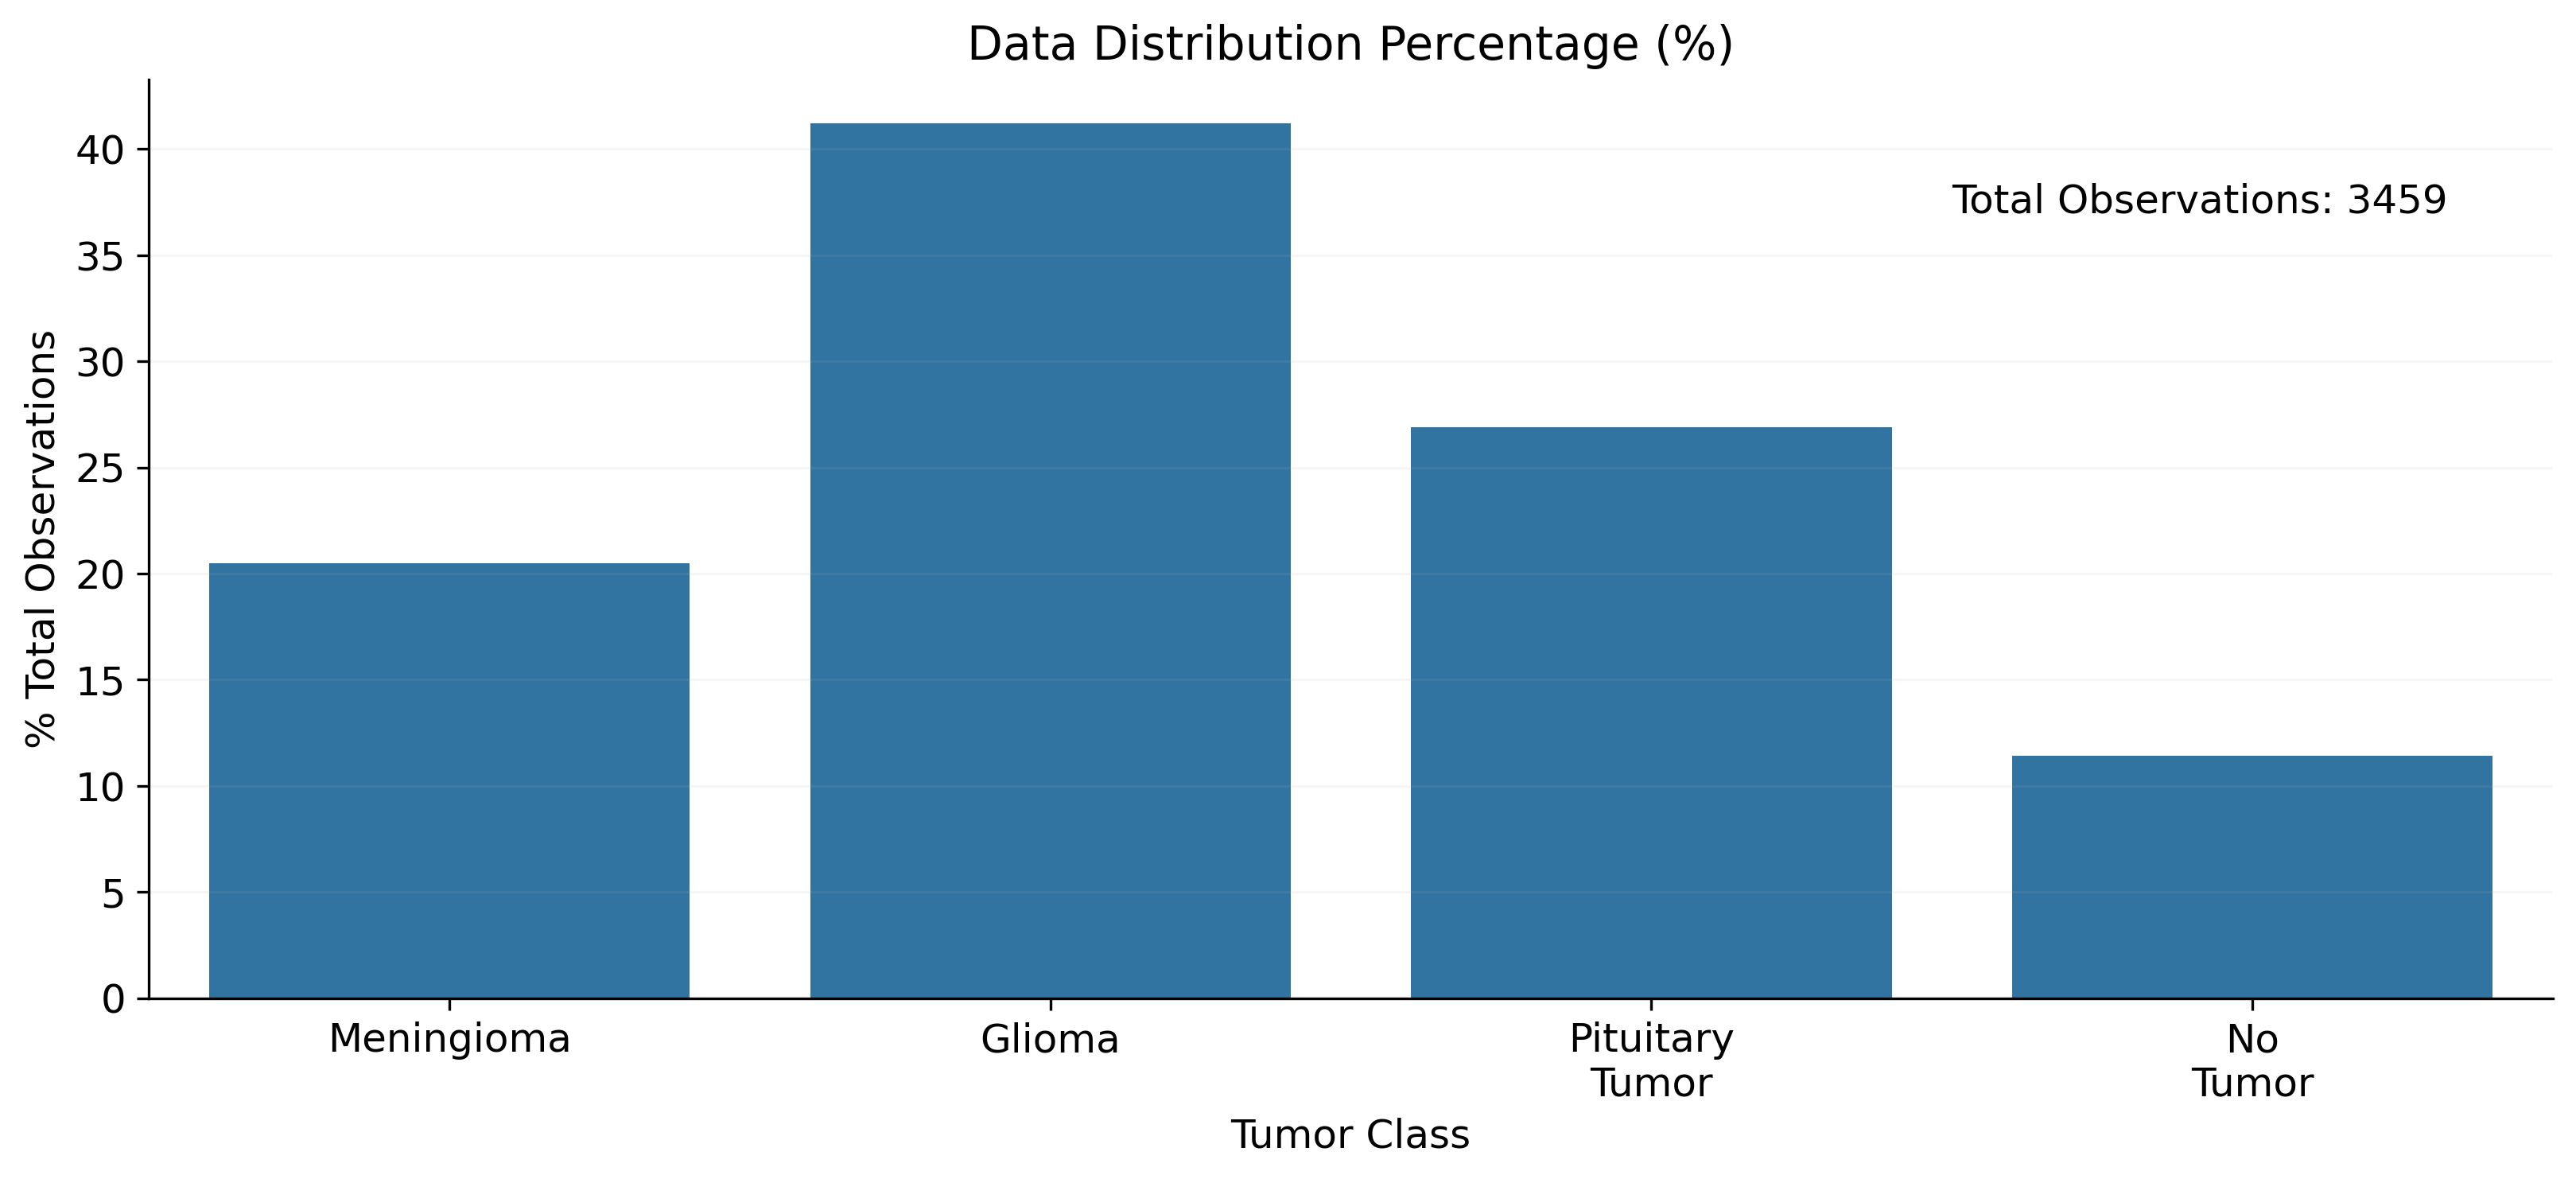

In [11]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

In [12]:
def mat_file_to_dict(filepath: str) -> dict:
    tumor_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary_tumor'}
    tumor_data_dict = {}
    with h5py.File(filepath, mode = 'r') as image_data:
        cjdata_struct = image_data['cjdata']
        tumor_data_dict['class'] = tumor_class[int(cjdata_struct['label'][0, 0])]
        tumor_data_dict['image'] = cjdata_struct['image'][:].transpose()
        tumor_data_dict['tumor_border'] = cjdata_struct['tumorBorder'][0]
        tumor_data_dict['tumor_mask'] = cjdata_struct['tumorMask'][:].transpose()
    return tumor_data_dict

In [13]:
def generate_img_from_mat(mat_file_data: dict) -> None:
    plt.figure(figsize = (15, 7))
    tumor_mri = plt.imshow(mat_file_data['image'], cmap = 'gray')
    plt.axis('off')

In [14]:
rootpath_dataset = "/content/drive/MyDrive/Deep_Learning/"
mat_dirname = 'Brain-Tumor-Images-Mat-Files'
training_dir = os.path.join(rootpath_dataset, 'Training')

m_count, g_count, p_count = (0, 0, 0)
for root, dirpath, filenames in os.walk(os.path.join(rootpath_dataset, mat_dirname)):
    for curr_file in filenames:
        mri_img_data = mat_file_to_dict(os.path.join(root, curr_file))
        tumor_class = mri_img_data['class']
        generate_img_from_mat(mri_img_data)
        plt.show()
        if tumor_class == 'meningioma':
            m_count += 1
            m_path = os.path.join(training_dir, 'meningioma')
            if not os.path.exists(m_path):
                os.mkdir(m_path)
            plt.savefig(os.path.join(m_path, f'M{m_count}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        elif tumor_class == 'glioma':
            g_count += 1
            g_path = os.path.join(training_dir, 'glioma')
            if not os.path.exists(g_path):
                os.mkdir(g_path)
            plt.savefig(os.path.join(g_path, f'G{g_count}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        elif tumor_class == 'pituitary_tumor':
            p_count += 1
            p_path = os.path.join(training_dir, 'pituitary_tumor')
            if not os.path.exists(p_path):
                os.mkdir(p_path)
            plt.savefig(os.path.join(p_path, f'P{p_count}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        else:
            pass
        plt.clf()



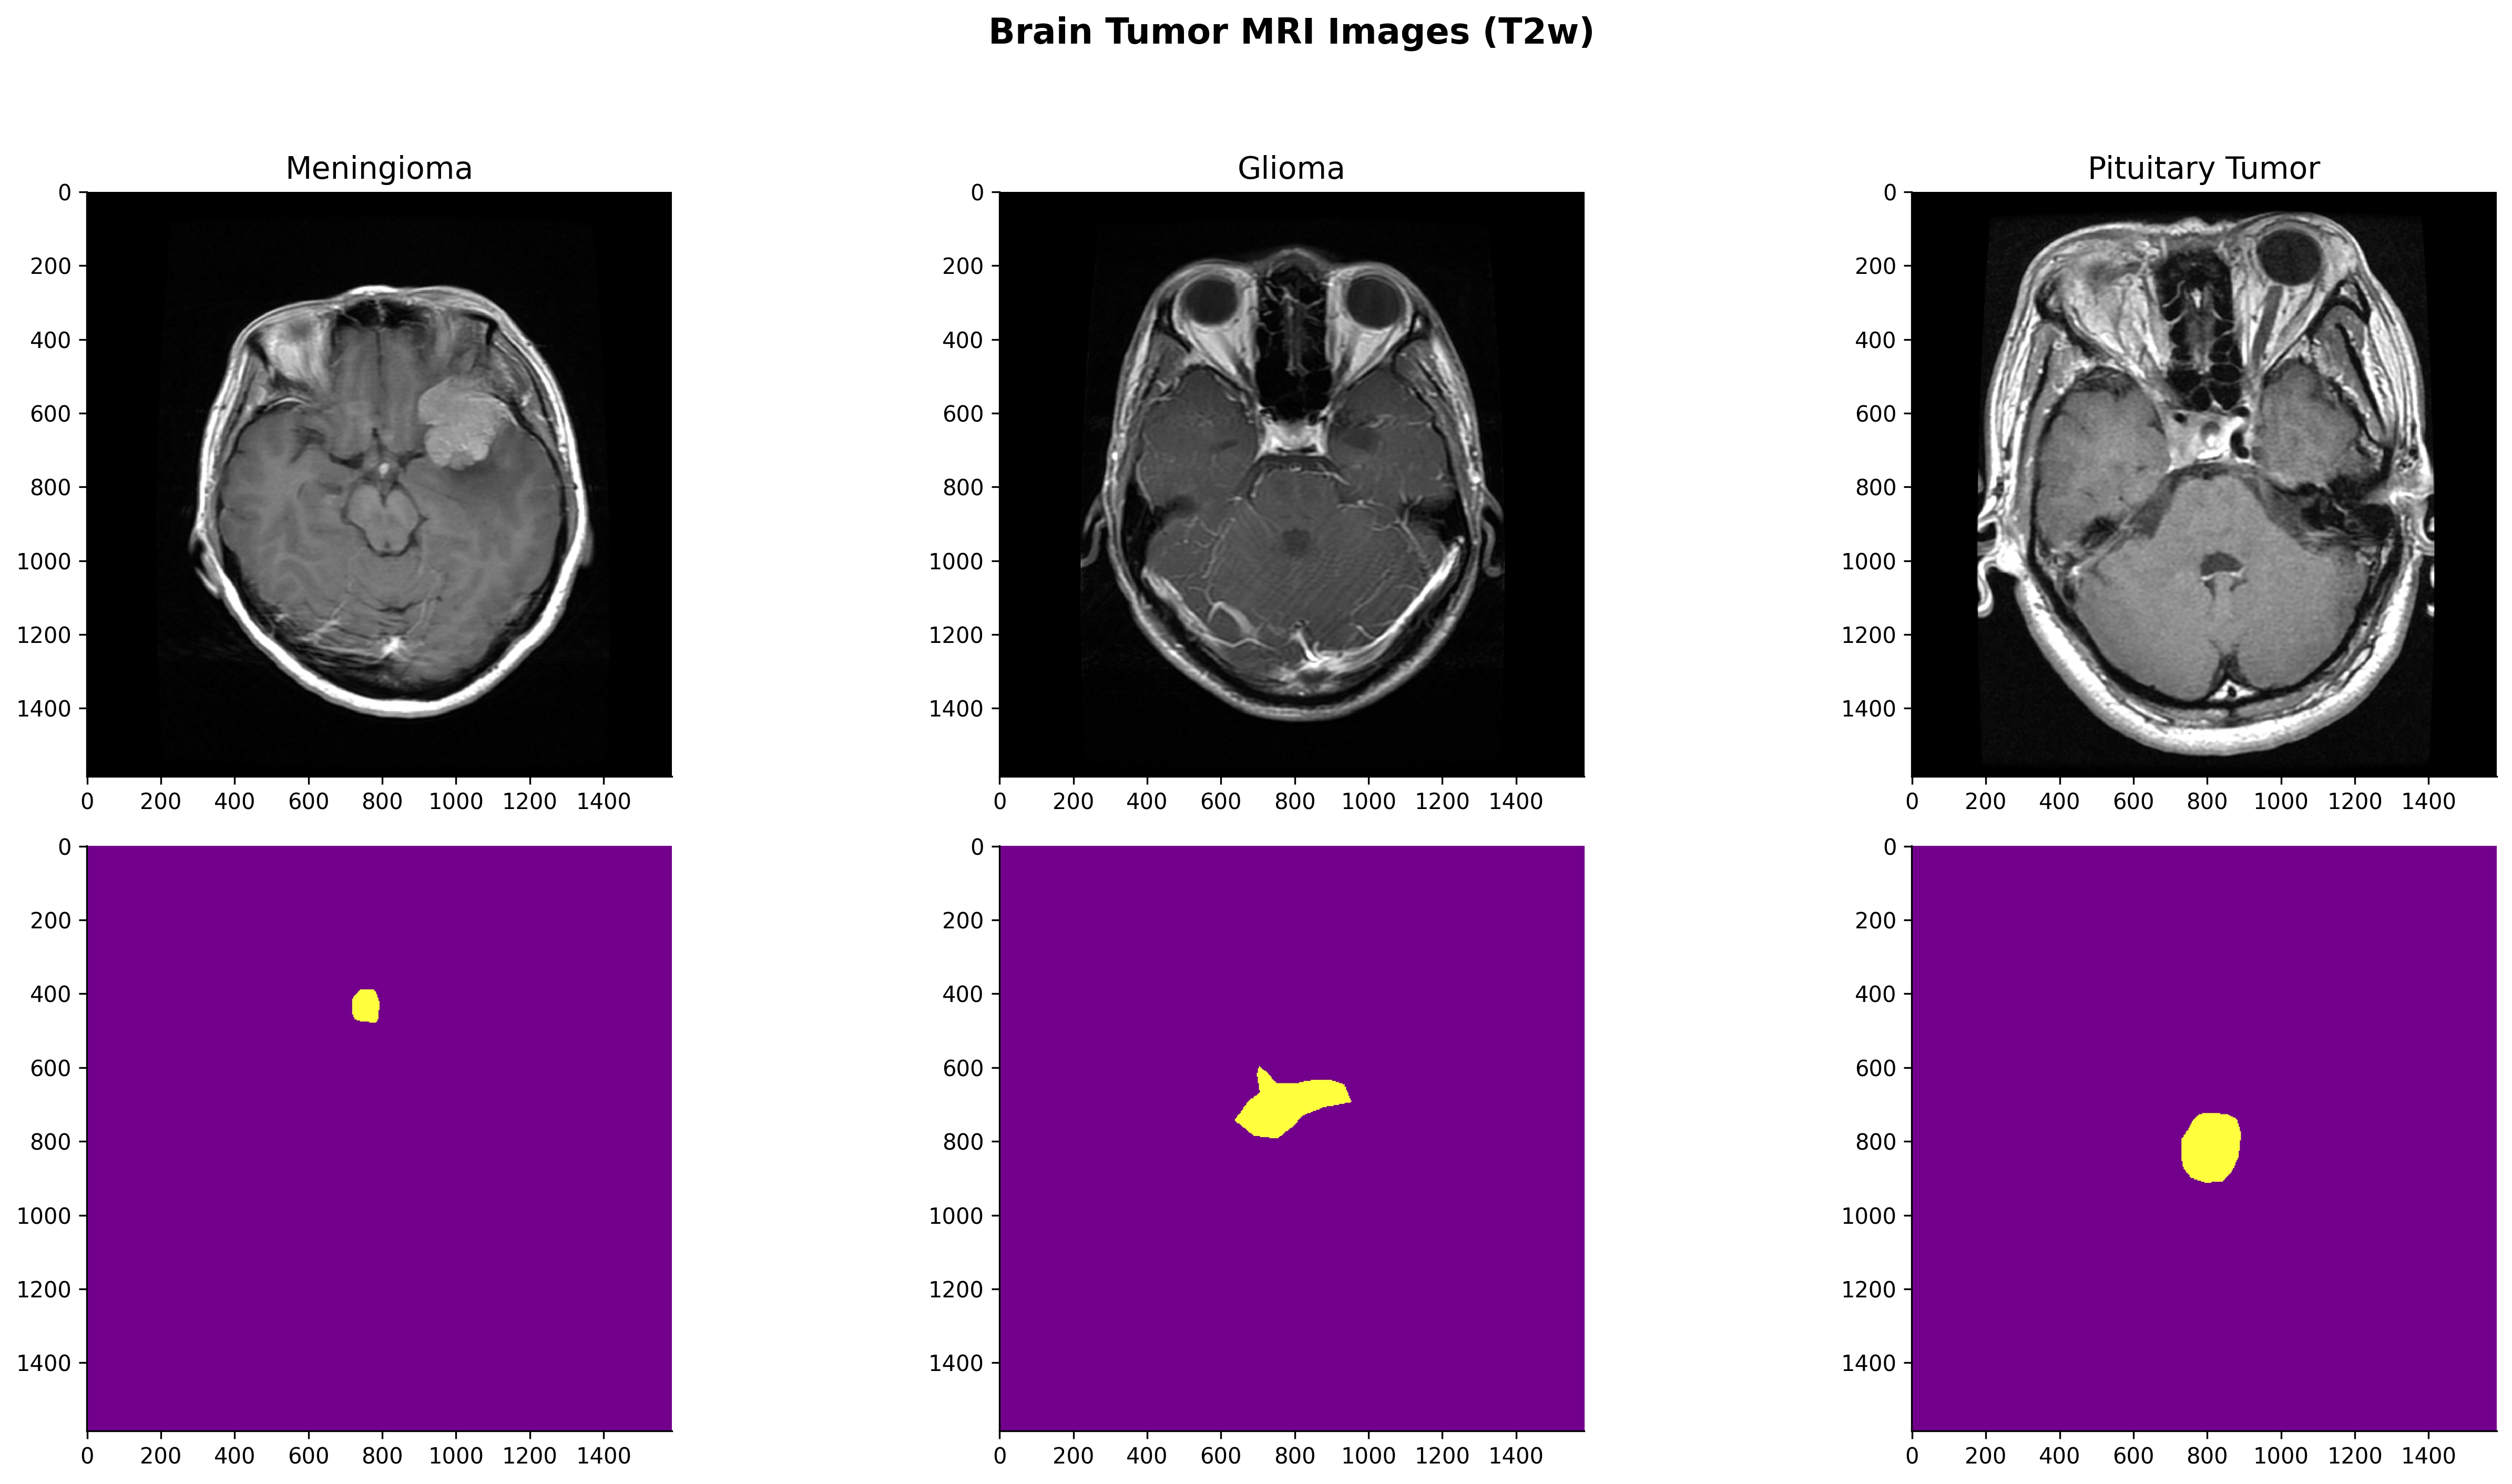

In [15]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize=16, fontweight='bold', y=1.04)

for curr_title, filename, curr_axis in zip(TUMOR_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

for filename, curr_axis in zip(MASK_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR))
fig.tight_layout()
sns.despine()

In [16]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))


In [17]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

image_filepaths      tumor_class
0  /content/drive/MyDrive/Deep_Learning/Brain-Tum...       meningioma
1  /content/drive/MyDrive/Deep_Learning/Brain-Tum...       meningioma
2  /content/drive/MyDrive/Deep_Learning/Brain-Tum...  pituitary_tumor
3  /content/drive/MyDrive/Deep_Learning/Brain-Tum...  pituitary_tumor
4  /content/drive/MyDrive/Deep_Learning/Brain-Tum...  pituitary_tumor

In [18]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3459 non-null   object
 1   tumor_class      3459 non-null   object
dtypes: object(2)
memory usage: 54.2+ KB


In [19]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df,
                                                      train_size = 0.70,
                                                      random_state = 42,
                                                      stratify = image_data_paths_df.tumor_class)

train_data, validation_data = train_test_split(intermediate_train_data,
                                               train_size = 0.80,
                                               random_state = 42,
                                               stratify = intermediate_train_data.tumor_class)

<ipython-input-20-c06a0d2e9292>:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha = 0.1)
<ipython-input-20-c06a0d2e9292>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
<ipython-input-20-c06a0d2e9292>:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha = 0.1)
<ipython-input-20-c06a0d2e9292>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
<ipython-input-20-c06a0d2e9292>:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid

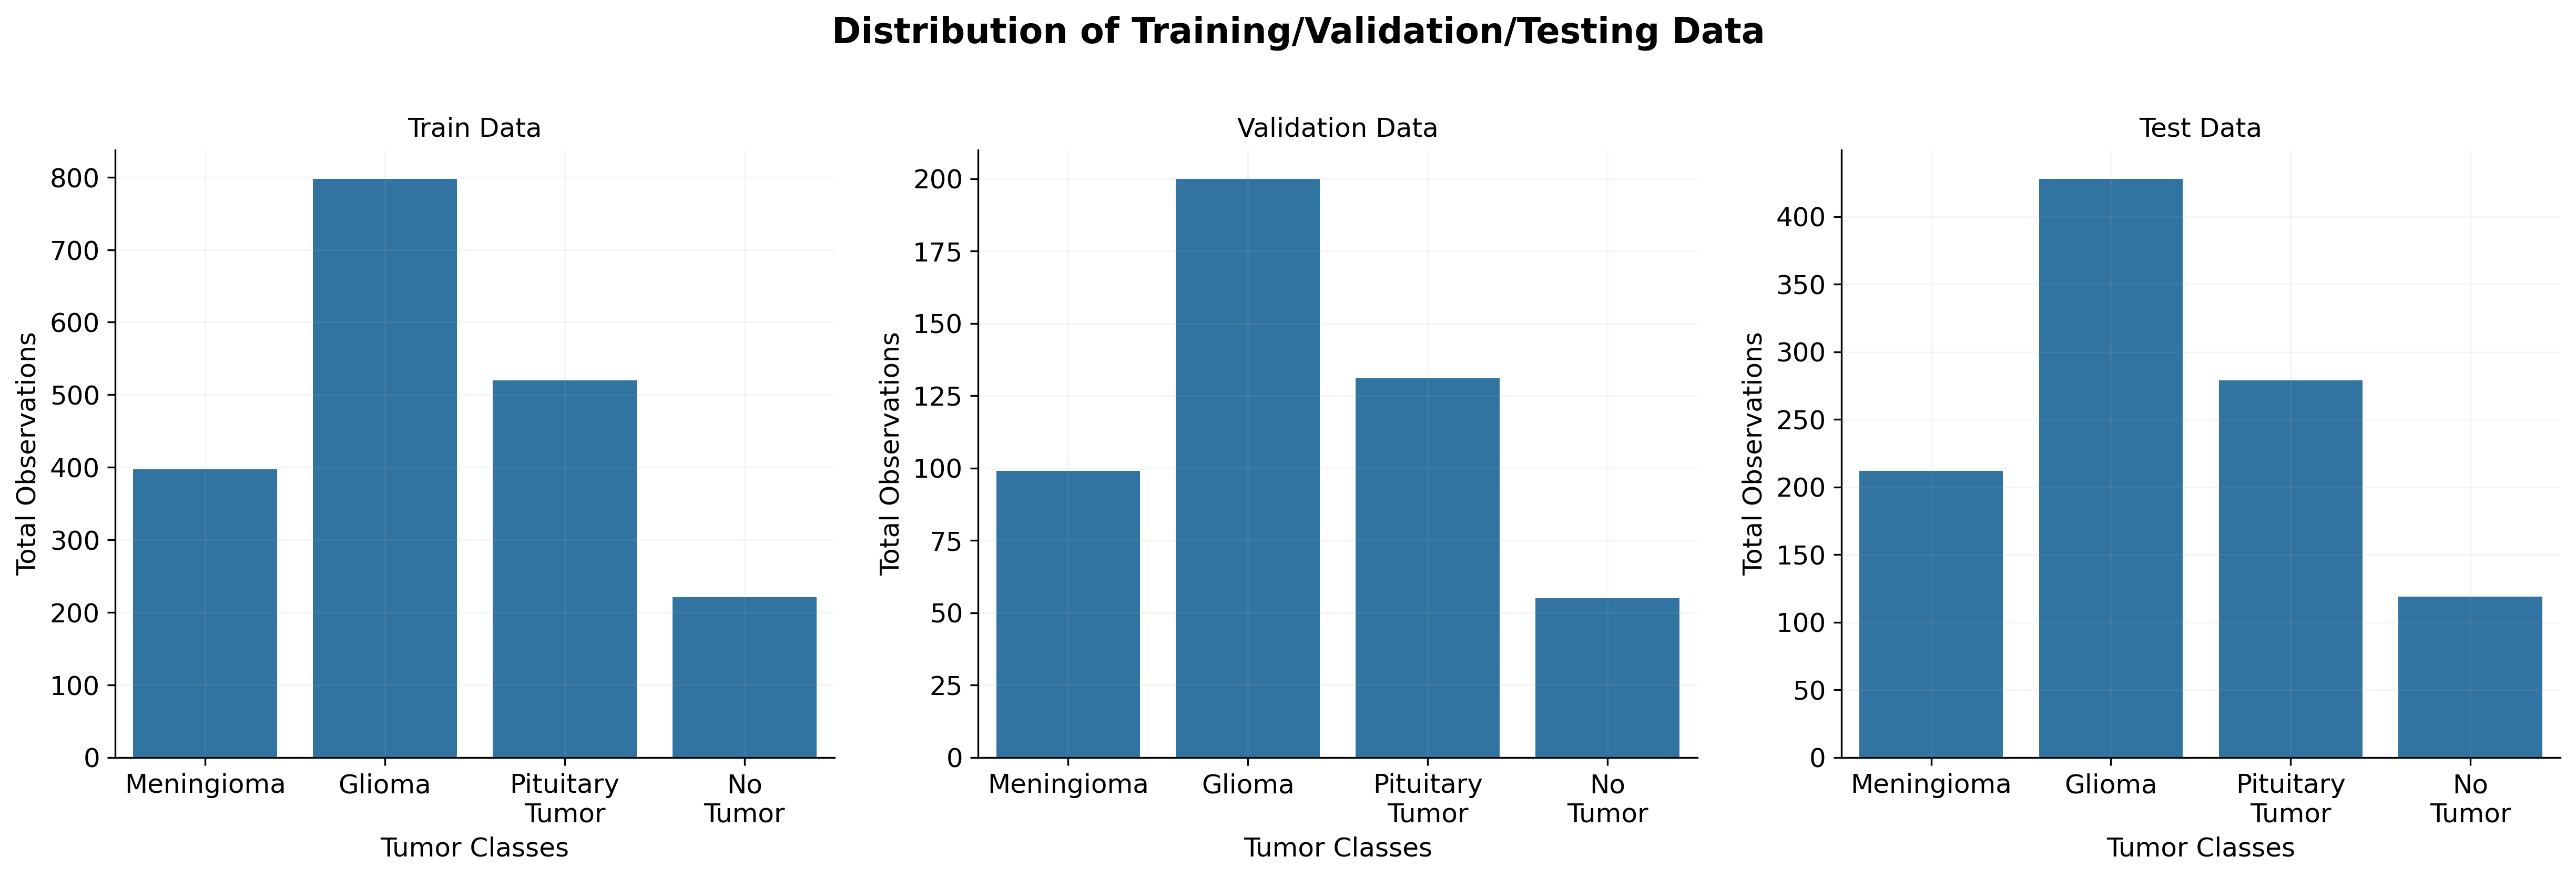

In [20]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontweight = 'bold', y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1])
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASS, ax = axes[2])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()

In [21]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15,
                            width_shift_range = 0.1,
                            zoom_range = 0.01,
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [22]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [23]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data,
                                                                  x_col = 'image_filepaths',
                                                                  y_col = 'tumor_class',
                                                                  seed = 42,
                                                                  batch_size = batch_size,
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1936 validated image filenames belonging to 4 classes.
Found 485 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


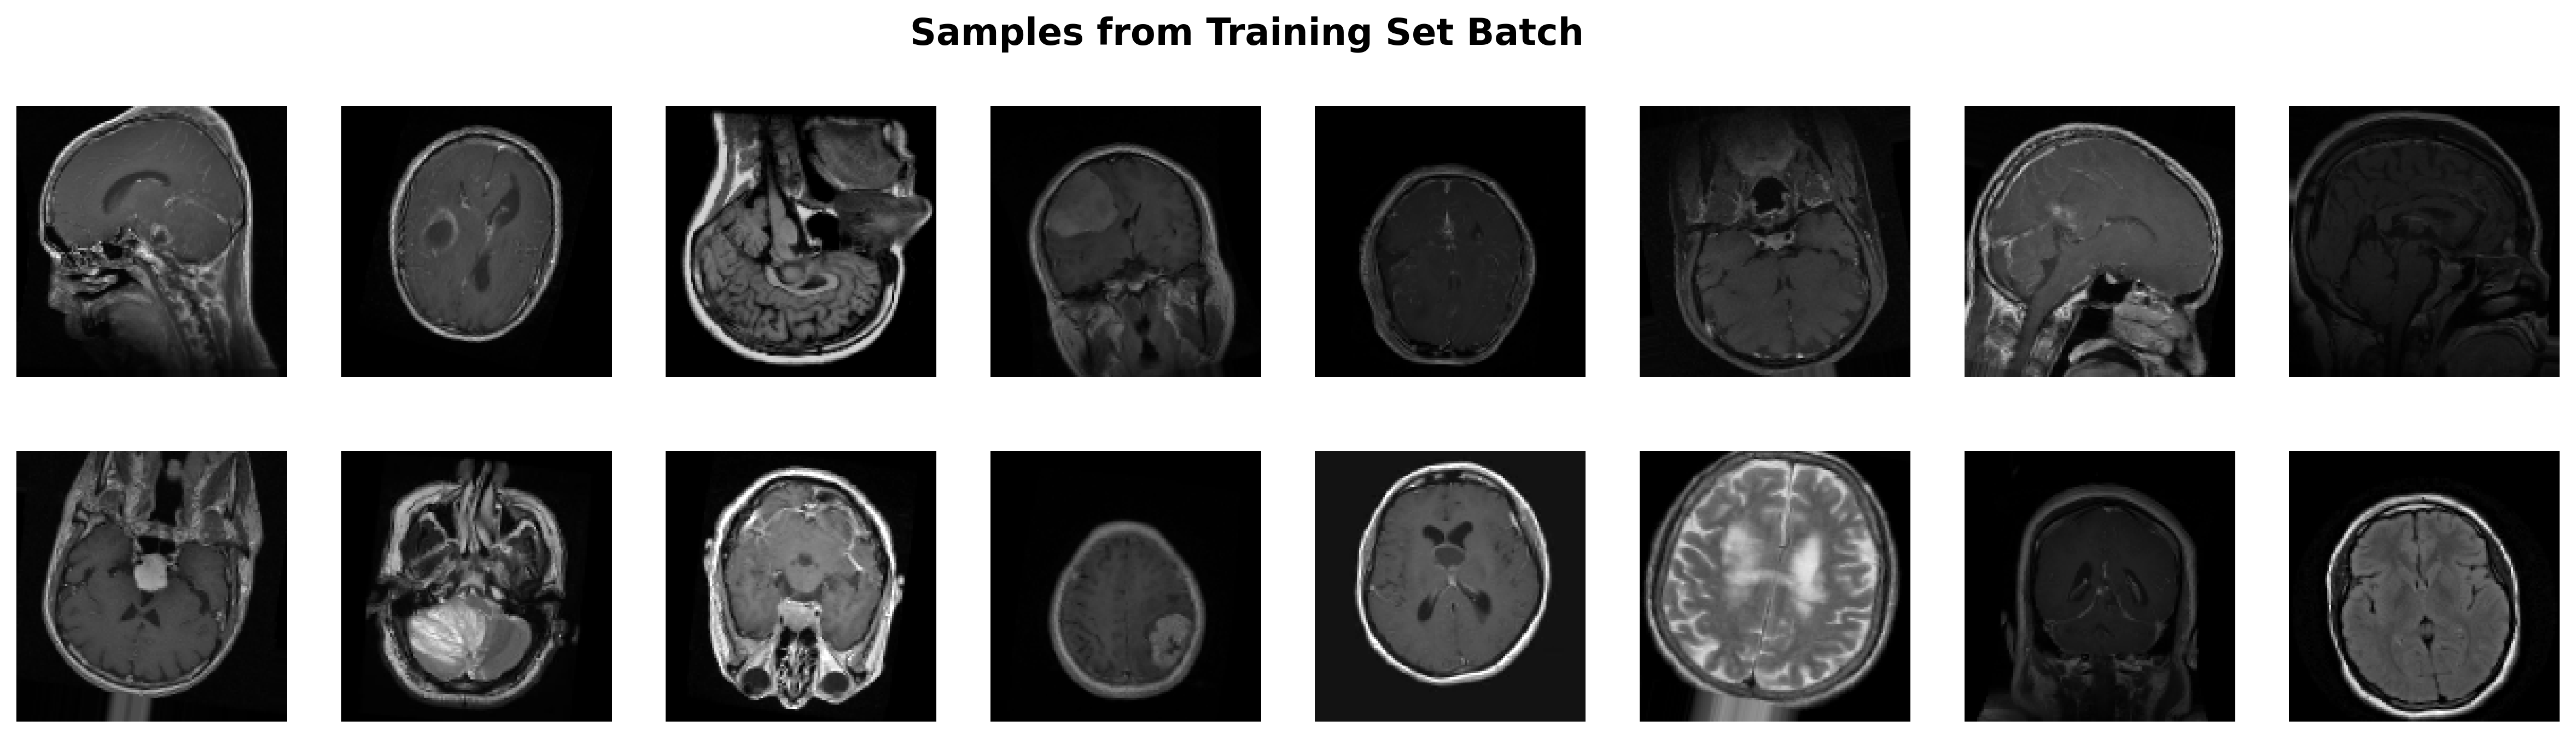

In [24]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontweight = 'bold')
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

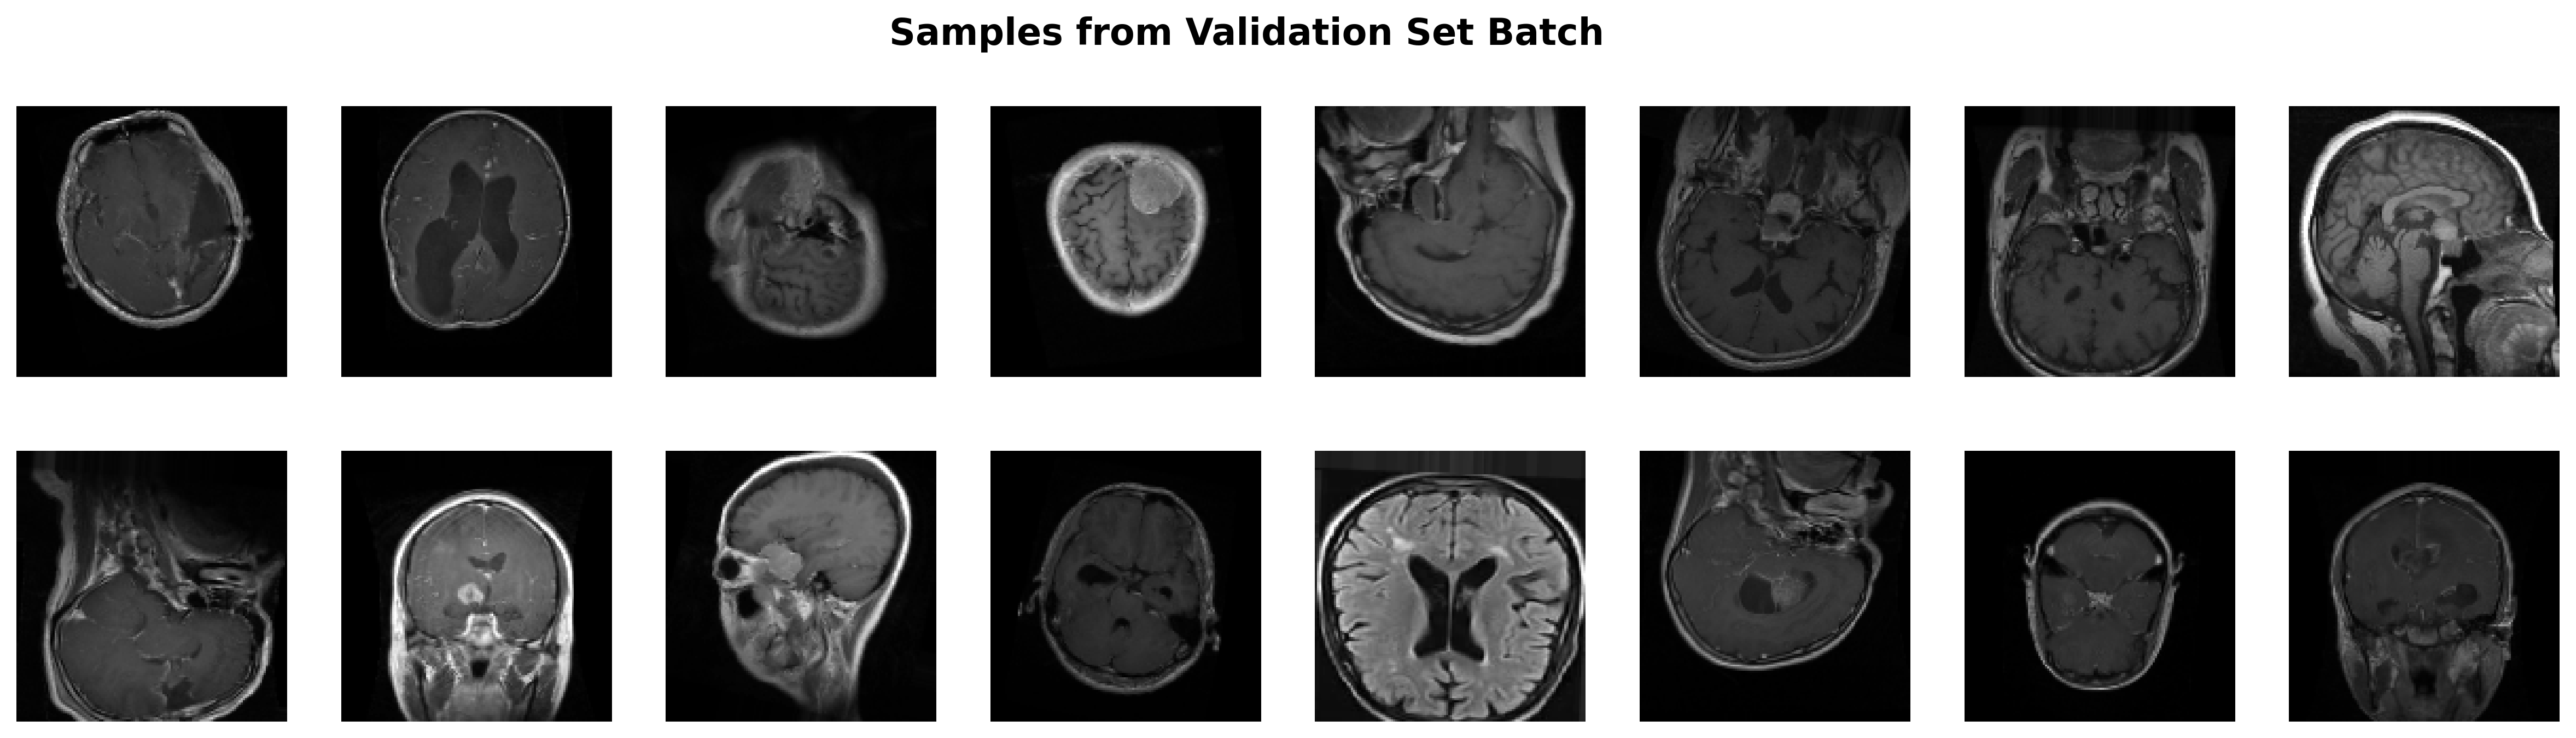

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontweight = 'bold')
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

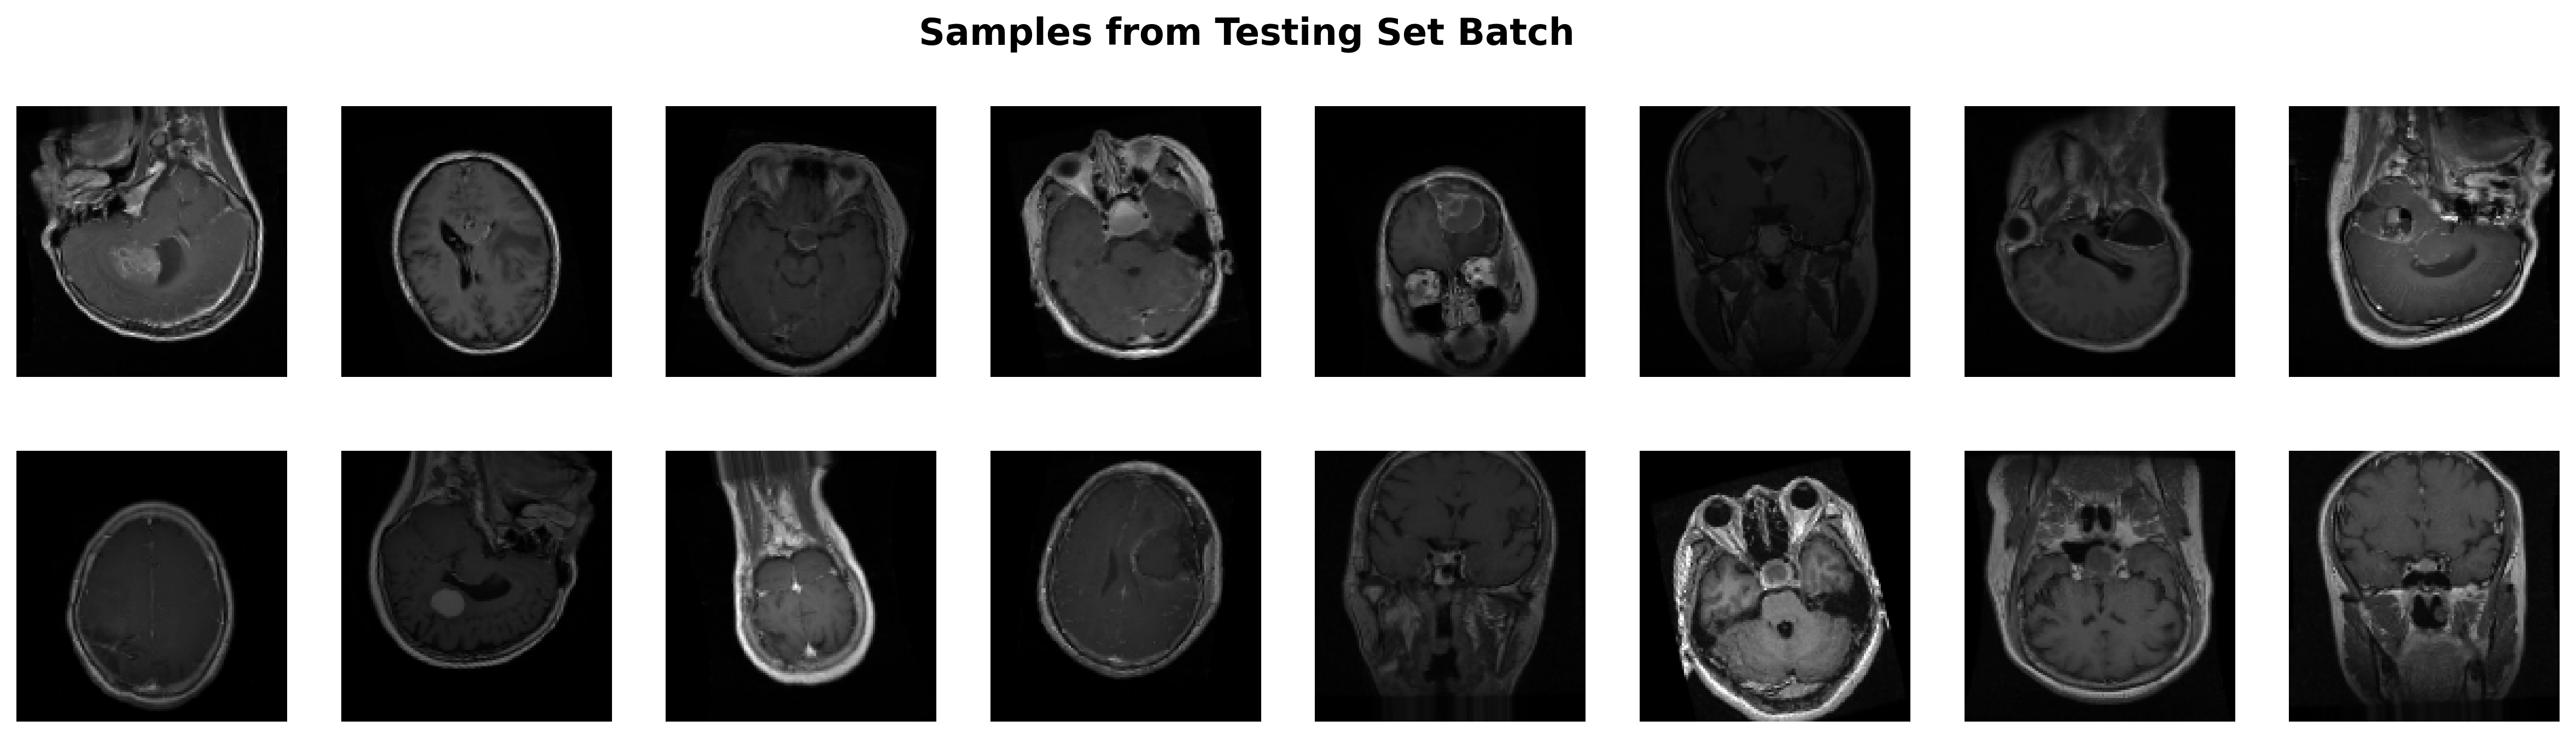

In [26]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontweight = 'bold')
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

In [27]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [28]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")
assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)



In [29]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define file paths properly
mlp_checkpoint_filepath = os.path.join(MLP_CHECKPOINT_DIR_PATH, 'weights.weights.h5')
alexnet_checkpoint_filepath = os.path.join(ALEXNET_CHECKPOINT_DIR_PATH, 'weights.weights.h5')
inceptionv3_checkpoint_filepath = os.path.join(INCEPTIONV3_CHECKPOINT_DIR_PATH, 'weights.weights.h5')

# MLP Callback
mlp_cp_callback = ModelCheckpoint(
    mlp_checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

# AlexNet Callback
alexnet_cp_callback = ModelCheckpoint(
    alexnet_checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

# InceptionV3 Callback
inceptionv3_cp_callback = ModelCheckpoint(
    inceptionv3_checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)


In [36]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontweight = 'bold', y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [44]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [51]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        mse = mean_squared_error(y_hat, y_preds)
        # Calculate RMSE by taking the square root of MSE.
        rmse = np.sqrt(mse)
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), rmse, curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

In [33]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten-Layer (Flatten)              │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 2048)                │     100,665,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-1 (Dropout)            │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-2 (Dropout)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-3 (Dense)               │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-3 (Dropout)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer-1 (Dense)               │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,290,372 (394.02 MB)

 Trainable params: 103,290,372 (394.02 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
try:
    # Check if GPU is available
    if tf.config.list_physical_devices('GPU'):
        device = '/GPU:0'
    else:
        device = '/CPU:0'

    with tf.device(device):
        mlp_train_history = mlp_model.fit(
            train_dataset,
            batch_size=batch_size,
            validation_data=validation_dataset,
            epochs=10,
            callbacks=[early_stopping]
        )
except RuntimeError as e:
    print(e)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 961s 16s/step - accuracy: 0.3560 - loss: 8.2070 - val_accuracy: 0.4103 - val_loss: 1.3482
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.4777 - loss: 1.2768 - val_accuracy: 0.5918 - val_loss: 1.1118
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.5110 - loss: 1.2041 - val_accuracy: 0.5814 - val_loss: 1.1088
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.4850 - loss: 1.2160 - val_accuracy: 0.6144 - val_loss: 1.1003
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.5442 - loss: 1.1110 - val_accuracy: 0.6041 - val_loss: 1.0290
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.5371 - loss: 1.1064 - val_accuracy: 0.6165 - val_loss: 1.0537
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.5766 - loss: 1.0872 - val_accuracy: 0.6124 - val_loss: 1.0258
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.5752 - loss: 1.0523 - val_accuracy: 0.5505 - 

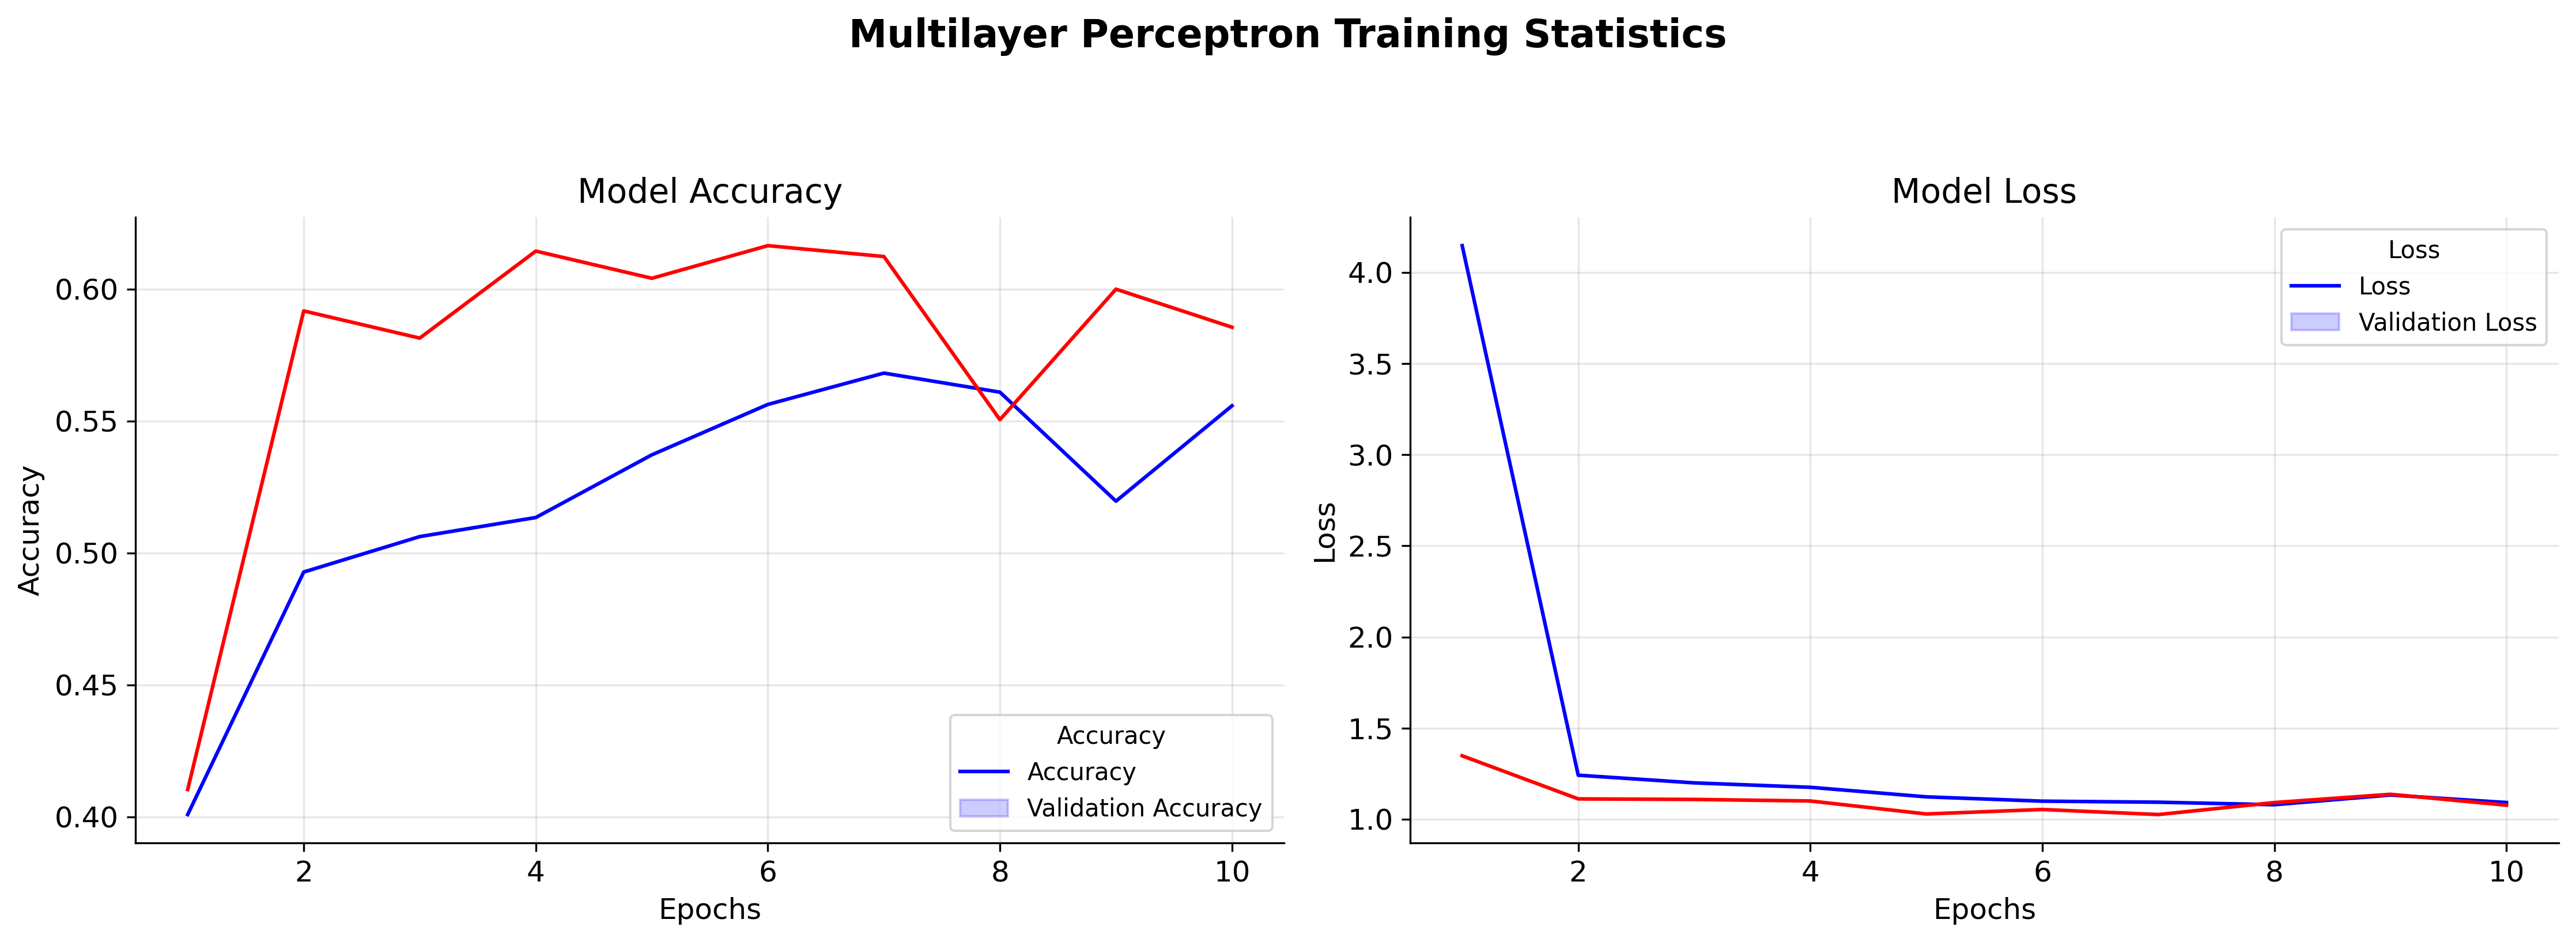

In [37]:
training_process_viz(pd.DataFrame(mlp_train_history.history),
                     plot_title = 'Multilayer Perceptron Training Statistics')

61/61 ━━━━━━━━━━━━━━━━━━━━ 56s 911ms/step


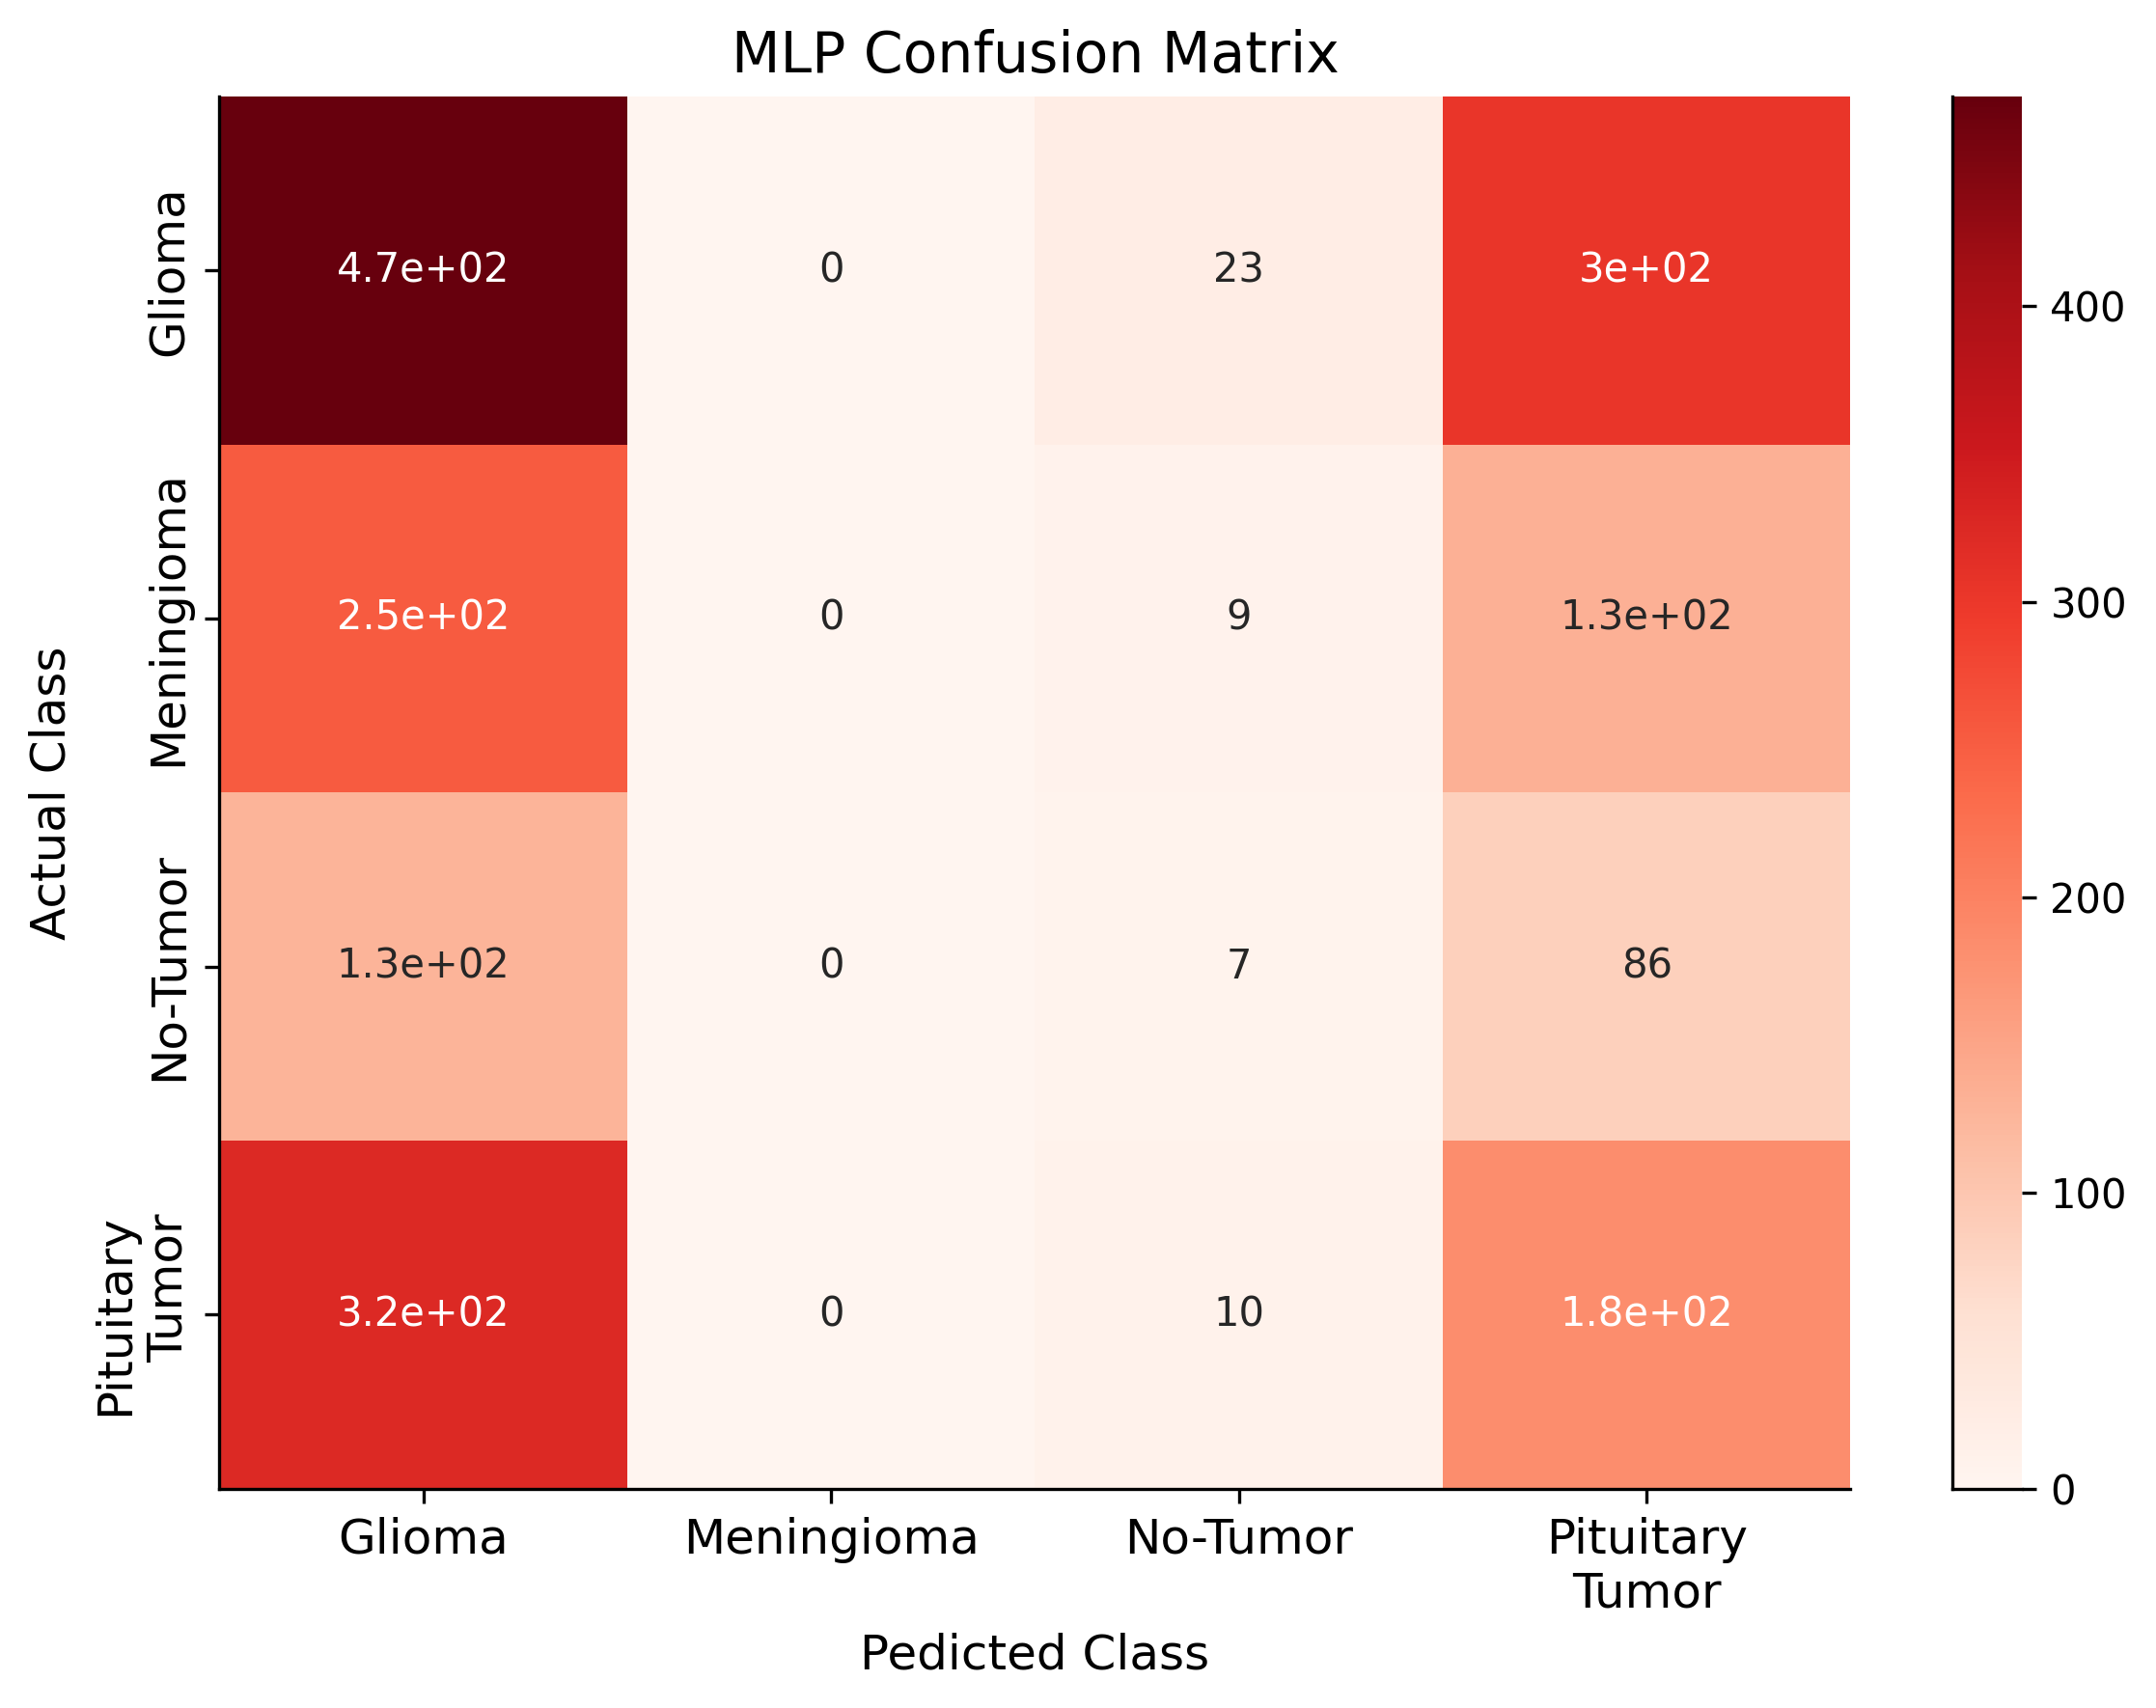

In [45]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

In [52]:
mlp_report_df = generate_report(mlp_model,
                                test_dataset = test_dataset,
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 918ms/step - accuracy: 0.5715 - loss: 1.0914
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 919ms/step


MAE       MSE      RMSE      Loss  \
Multi-Layer-Perceptron Model  1.397881  3.534682  1.880075  1.089259   

                              Accuracy  F1-Score  
Multi-Layer-Perceptron Model  0.579961  0.365125

In [53]:

alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D-1 (Conv2D)                    │ (None, 30, 30, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-1                │ (None, 30, 30, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max-Pooling-1 (MaxPooling2D)         │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D-2 (Conv2D)                    │ (None, 14, 14, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-2                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max-Pooling-2 (MaxPooling2D)         │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D-3 (Conv2D)                    │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-3                │ (None, 6, 6, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D-4 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-4                │ (None, 6, 6, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D-5 (Conv2D)                    │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Batch-Normalization-5                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max-Pooling-3 (MaxPooling2D)         │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten-Layer-1 (Flatten)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-1 (Dropout)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-2 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout-Layer-2 (Dropout)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 4)                   │             2

 Total params: 3,892,420 (14.85 MB)

 Trainable params: 3,889,668 (14.84 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [55]:
# Check for and assign device locations
try:
    # Check if GPU is available
    if tf.config.list_physical_devices('GPU'):
        gpu_device_location = '/GPU:0'  # Assign GPU location
    else:
        gpu_device_location = None  # No GPU available

    # Check for TPU (optional, add logic if needed)
    tpu_device_location = None
    tpu_strategy = None

    # Default to CPU if no GPU or TPU
    cpu_device_location = '/CPU:0'

except RuntimeError as e:
    print(e)

# Now use the device locations in your training code
with tf.device(gpu_device_location) if gpu_device_location else tf.device(cpu_device_location):  # Simplified condition
    alexnet_train_history = alexnet_cnn.fit(train_dataset,
                                            batch_size = batch_size,
                                            validation_data = validation_dataset,
                                            epochs = 10,
                                            callbacks = [early_stopping, alexnet_cp_callback])

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3369 - loss: 2.5420
Epoch 1: saving model to /content/drive/MyDrive/Deep_Learning/Model-Checkpoints/AlexNet-CNN/weights.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3376 - loss: 2.5315 - val_accuracy: 0.3093 - val_loss: 1.3853
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4183 - loss: 1.3626
Epoch 2: saving model to /content/drive/MyDrive/Deep_Learning/Model-Checkpoints/AlexNet-CNN/weights.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4183 - loss: 1.3623 - val_accuracy: 0.3175 - val_loss: 1.4380
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4364 - loss: 1.2475
Epoch 3: saving model to /content/drive/MyDrive/Deep_Learning/Model-Checkpoints/AlexNet-CNN/weights.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4368 - loss: 1.2472 - val_accuracy: 0.2701 - val_loss: 1.4538
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4780 - 

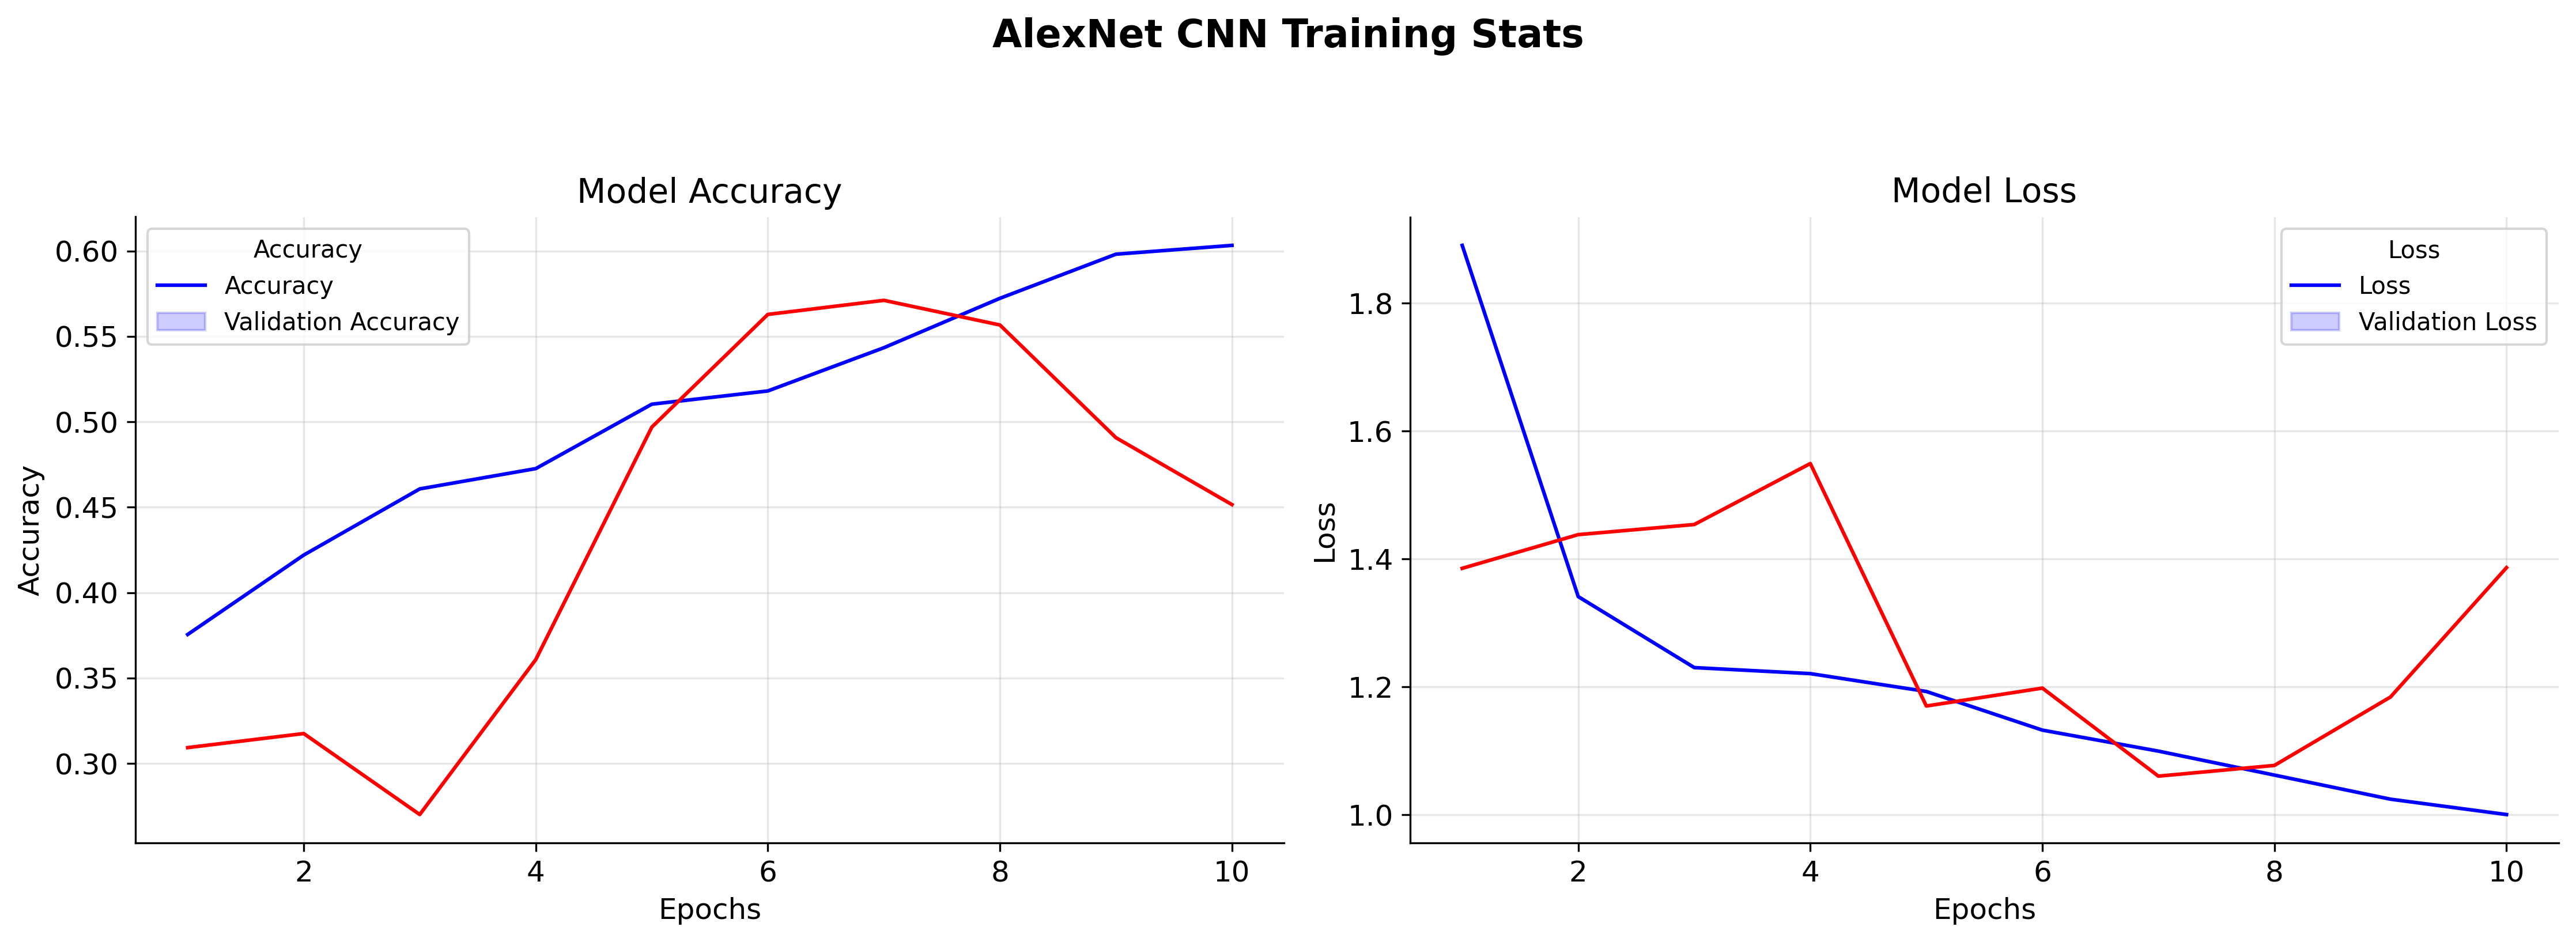

In [56]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


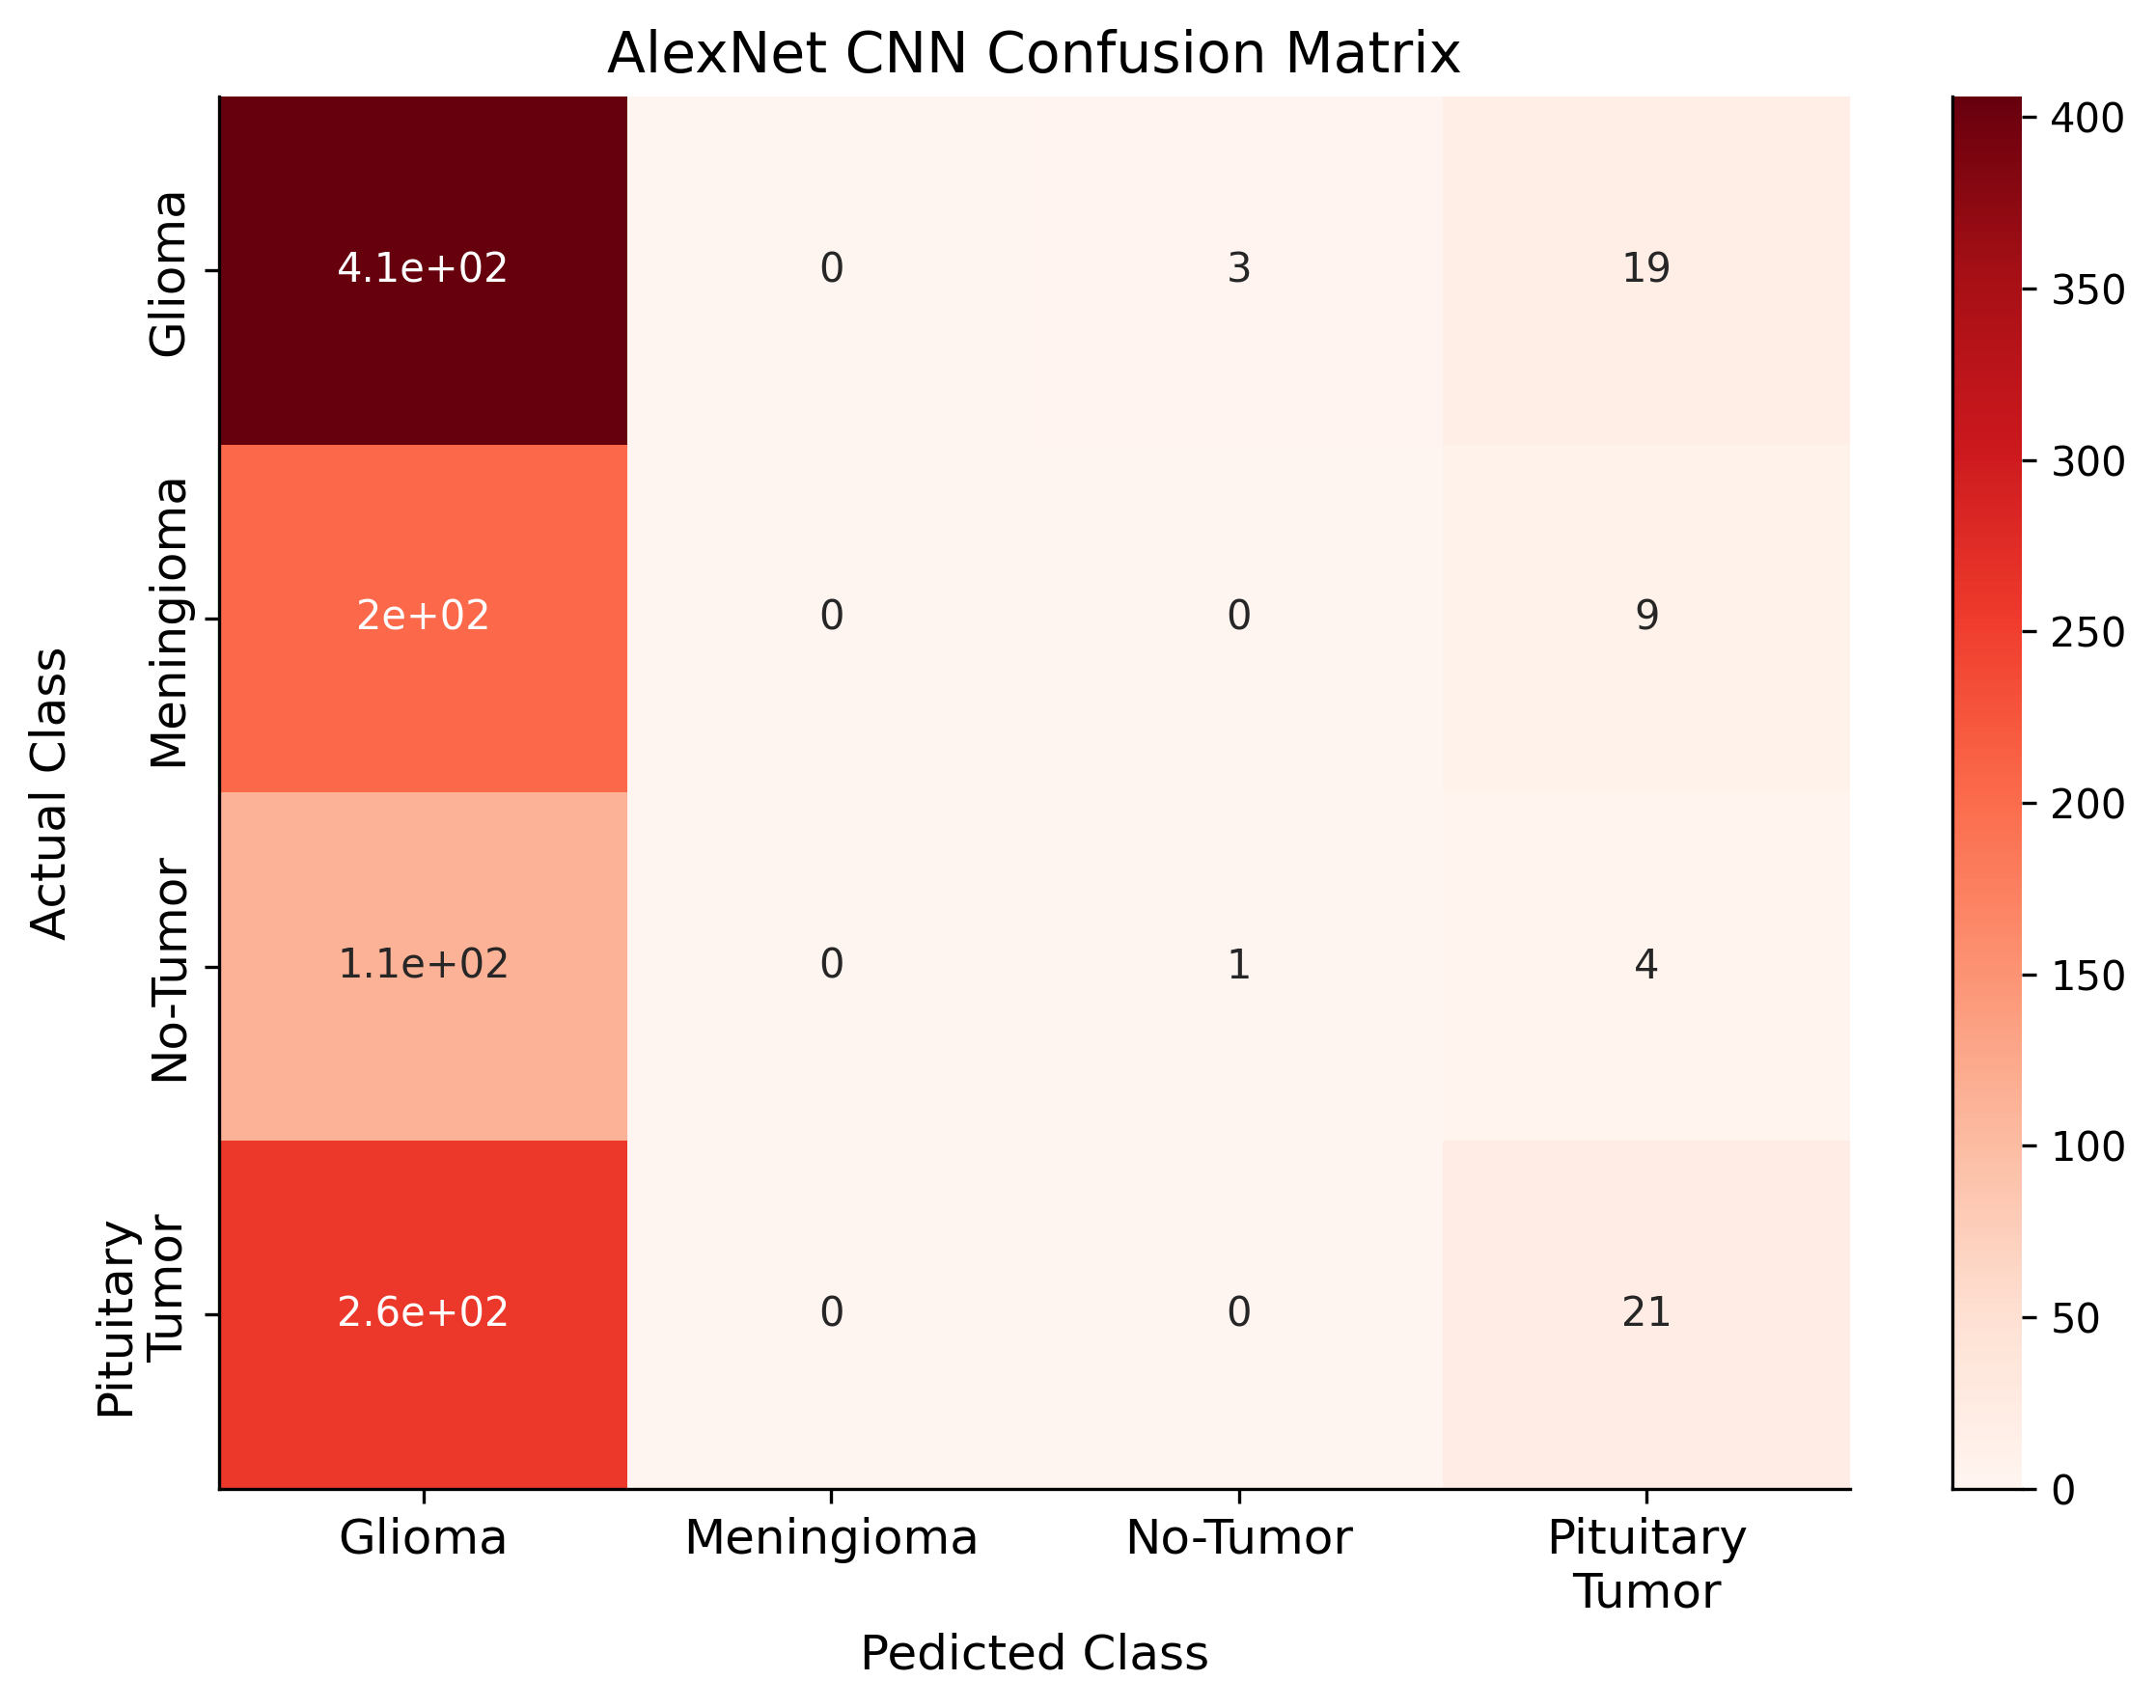

In [58]:
with tf.device(gpu_device_location) if gpu_device_location else tf.device(cpu_device_location):
    confusion_matrix_viz(alexnet_cnn,
                         test_dataset,
                         plot_title = "AlexNet CNN Confusion Matrix")

In [59]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4820 - loss: 1.3380
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


MAE       MSE     RMSE     Loss  Accuracy  F1-Score
AlexNet CNN  1.235067  3.067437  1.75141  1.34533  0.454721  0.415222

In [60]:
inception_v3_model = InceptionV3(include_top = False,
                                 input_shape = (image_size, image_size, 3),
                                 pooling = 'avg')
inception_v3_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [61]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [62]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    inception_model_train_history = inception_cnn_model.fit(train_dataset,
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset,
                                                            epochs = 15,
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])


Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4244 - loss: 6.9528
Epoch 1: saving model to /content/drive/MyDrive/Deep_Learning/Model-Checkpoints/InceptionV3/weights.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.4264 - loss: 6.8935 - val_accuracy: 0.6763 - val_loss: 0.7845
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7122 - loss: 0.7328
Epoch 2: saving model to /content/drive/MyDrive/Deep_Learning/Model-Checkpoints/InceptionV3/weights.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7124 - loss: 0.7322 - val_accuracy: 0.7320 - val_loss: 0.6710
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7383 - loss: 0.6346
Epoch 3: saving model to /content/drive/MyDrive/Deep_Learning/Model-Checkpoints/InceptionV3/weights.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7385 - loss: 0.6343 - val_accuracy: 0.7134 - val_loss: 0.7331
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7772 - 

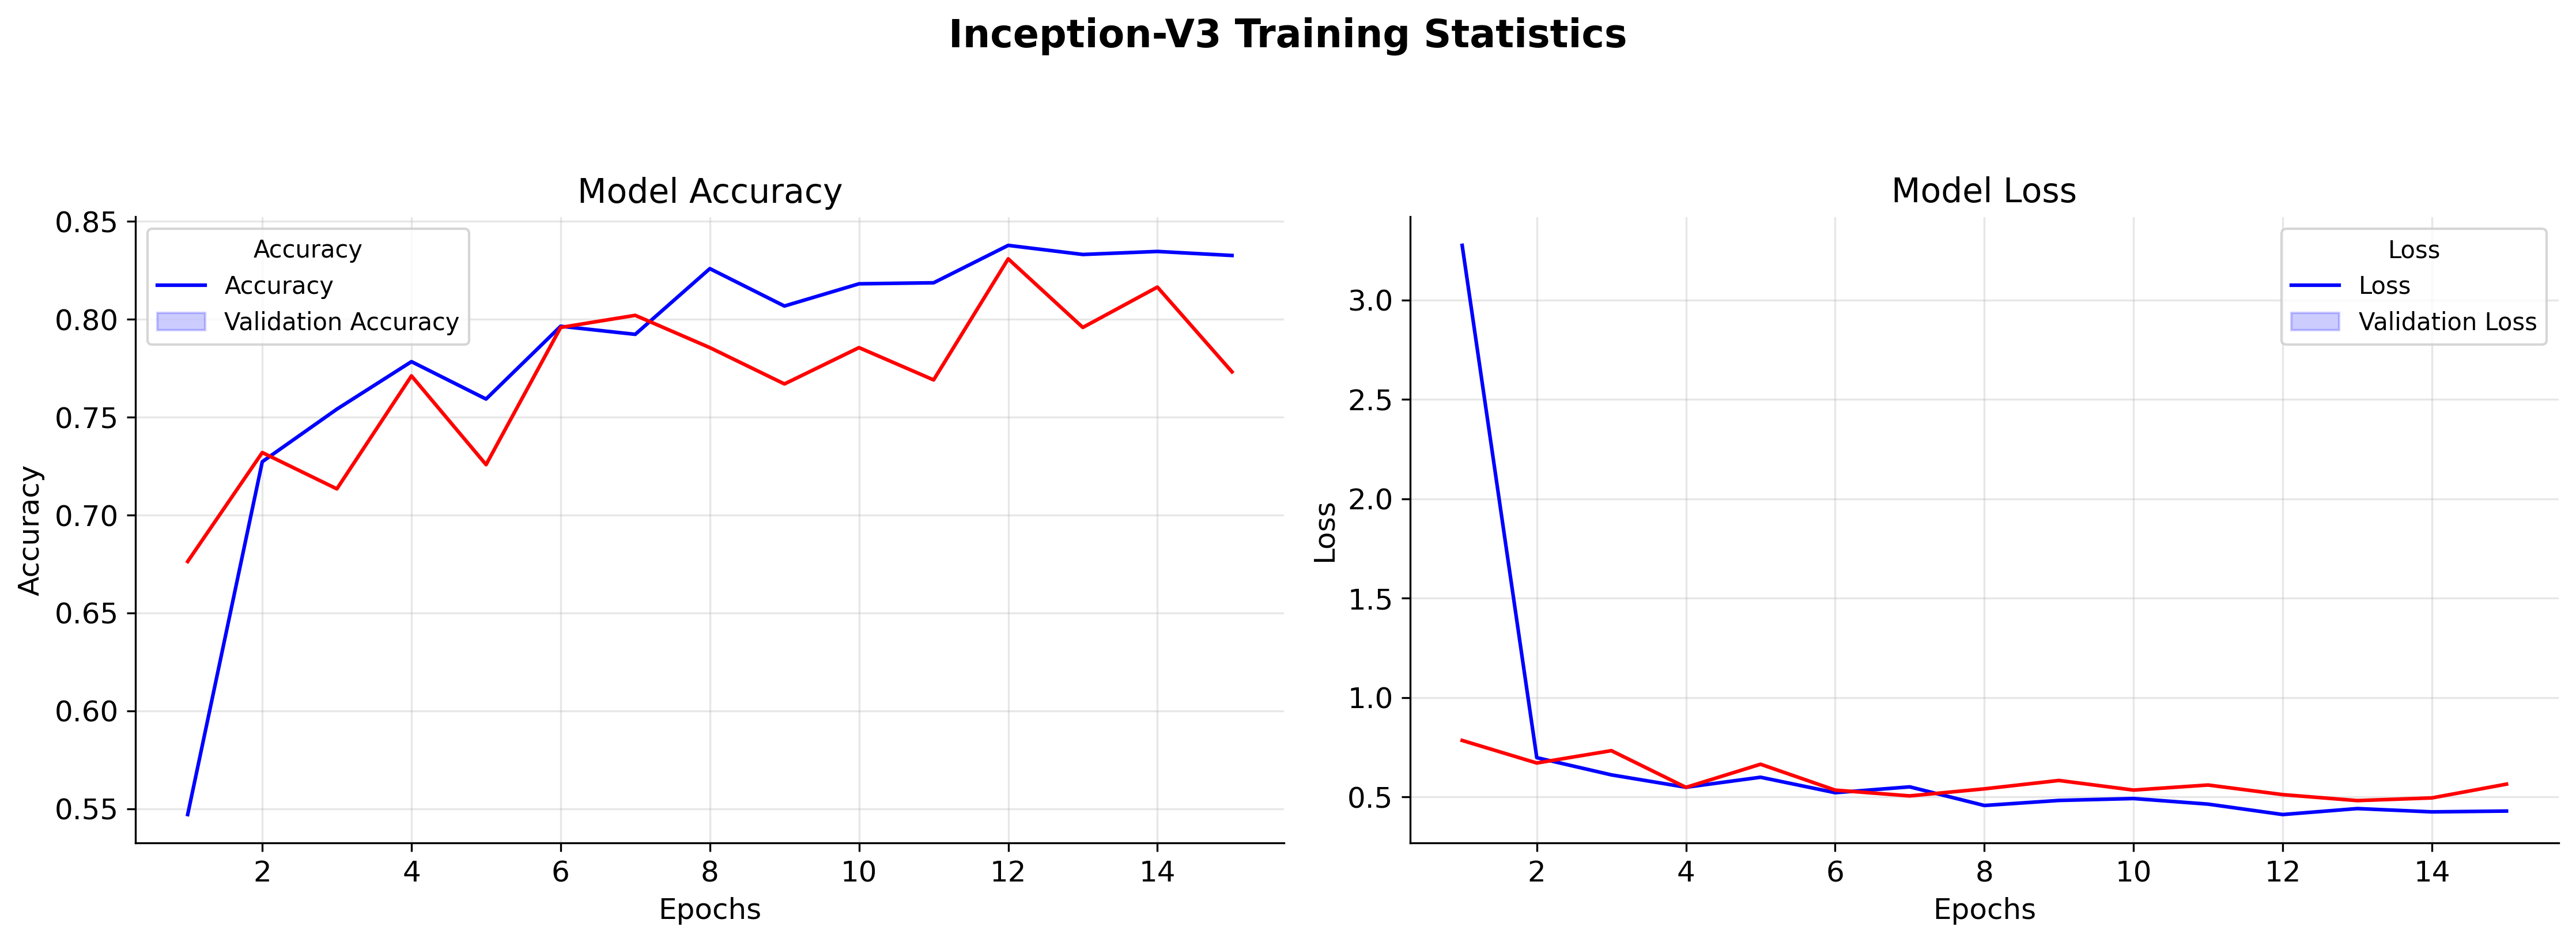

In [63]:
training_process_viz(pd.DataFrame(inception_model_train_history.history),
                     plot_title = 'Inception-V3 Training Statistics')

33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step


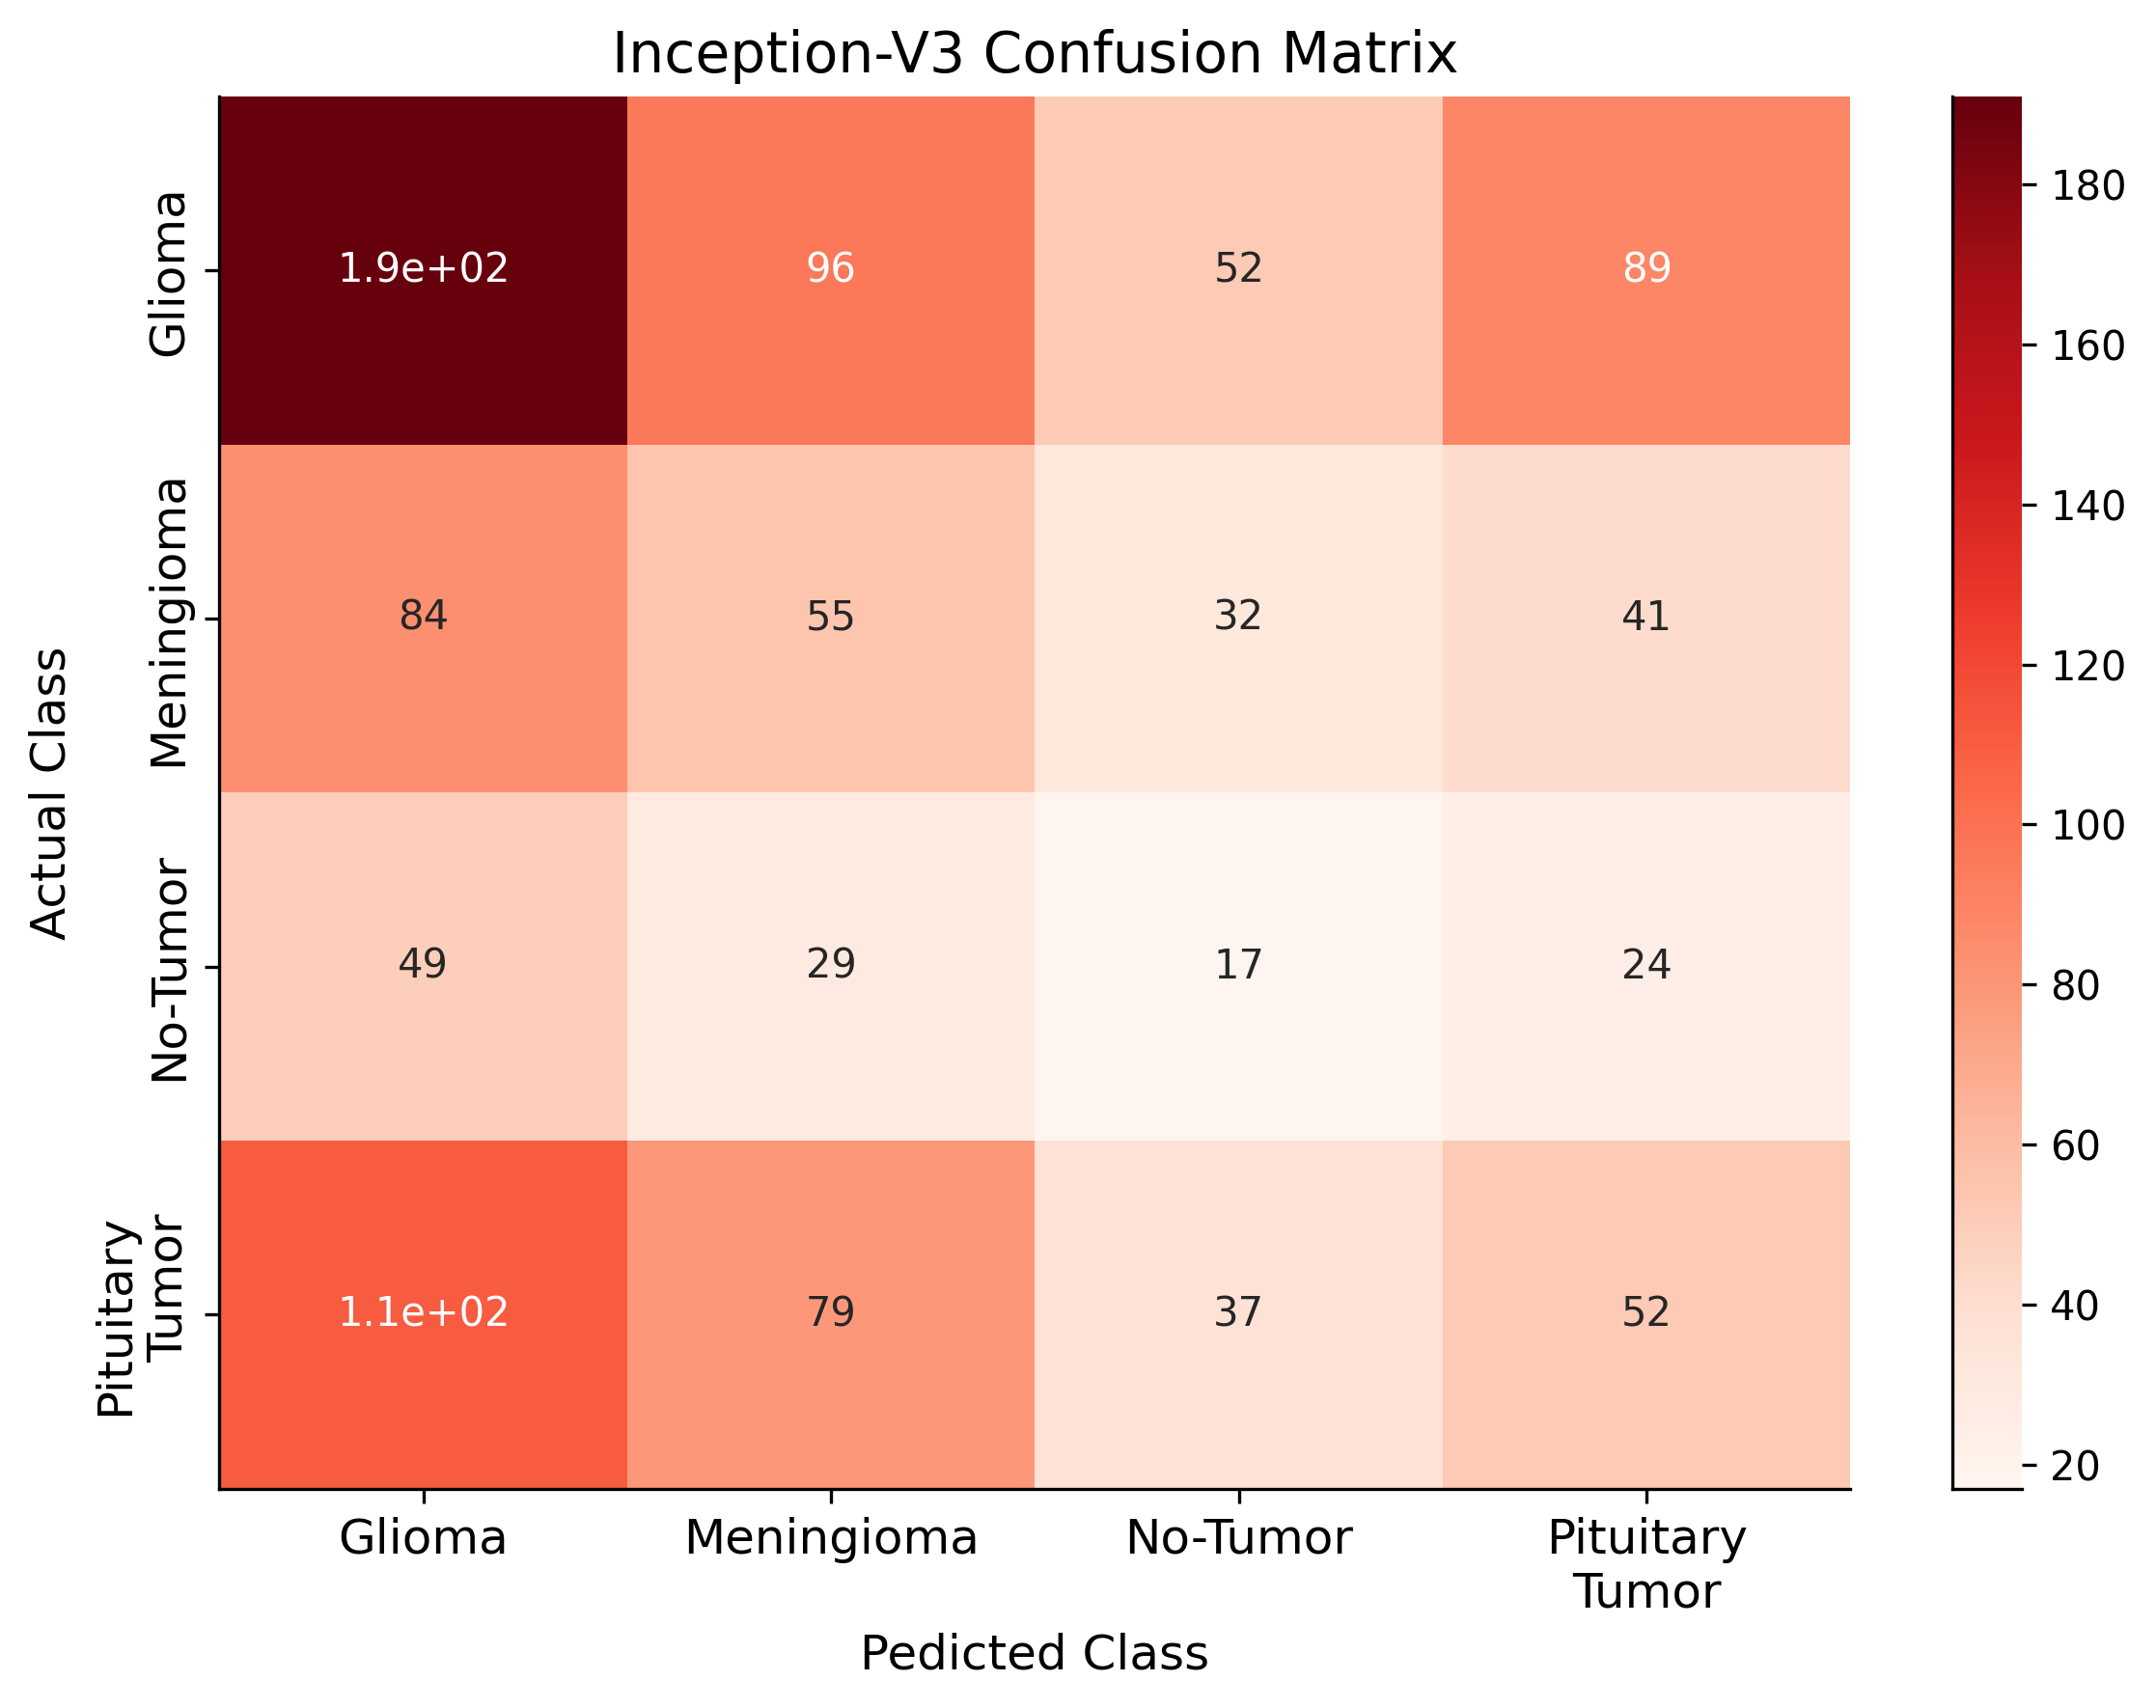

In [65]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location): # Changed cpu_device_name to cpu_device_location
    confusion_matrix_viz(inception_cnn_model,
                         test_dataset,
                         plot_title = "Inception-V3 Confusion Matrix")

In [66]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

33/33 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8117 - loss: 0.4964
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step


MAE       MSE      RMSE     Loss  Accuracy  F1-Score
InceptionV3  1.303468  2.918112  1.708248  0.50655  0.802505  0.303468

In [69]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
final_report_df

MAE       MSE      RMSE      Loss  \
Multi-Layer-Perceptron Model  1.397881  3.534682  1.880075  1.089259   
AlexNet CNN                   1.235067  3.067437  1.751410  1.345330   
InceptionV3                   1.303468  2.918112  1.708248  0.506550   

                              Accuracy  F1-Score  
Multi-Layer-Perceptron Model  0.579961  0.365125  
AlexNet CNN                   0.454721  0.415222  
InceptionV3                   0.802505  0.303468

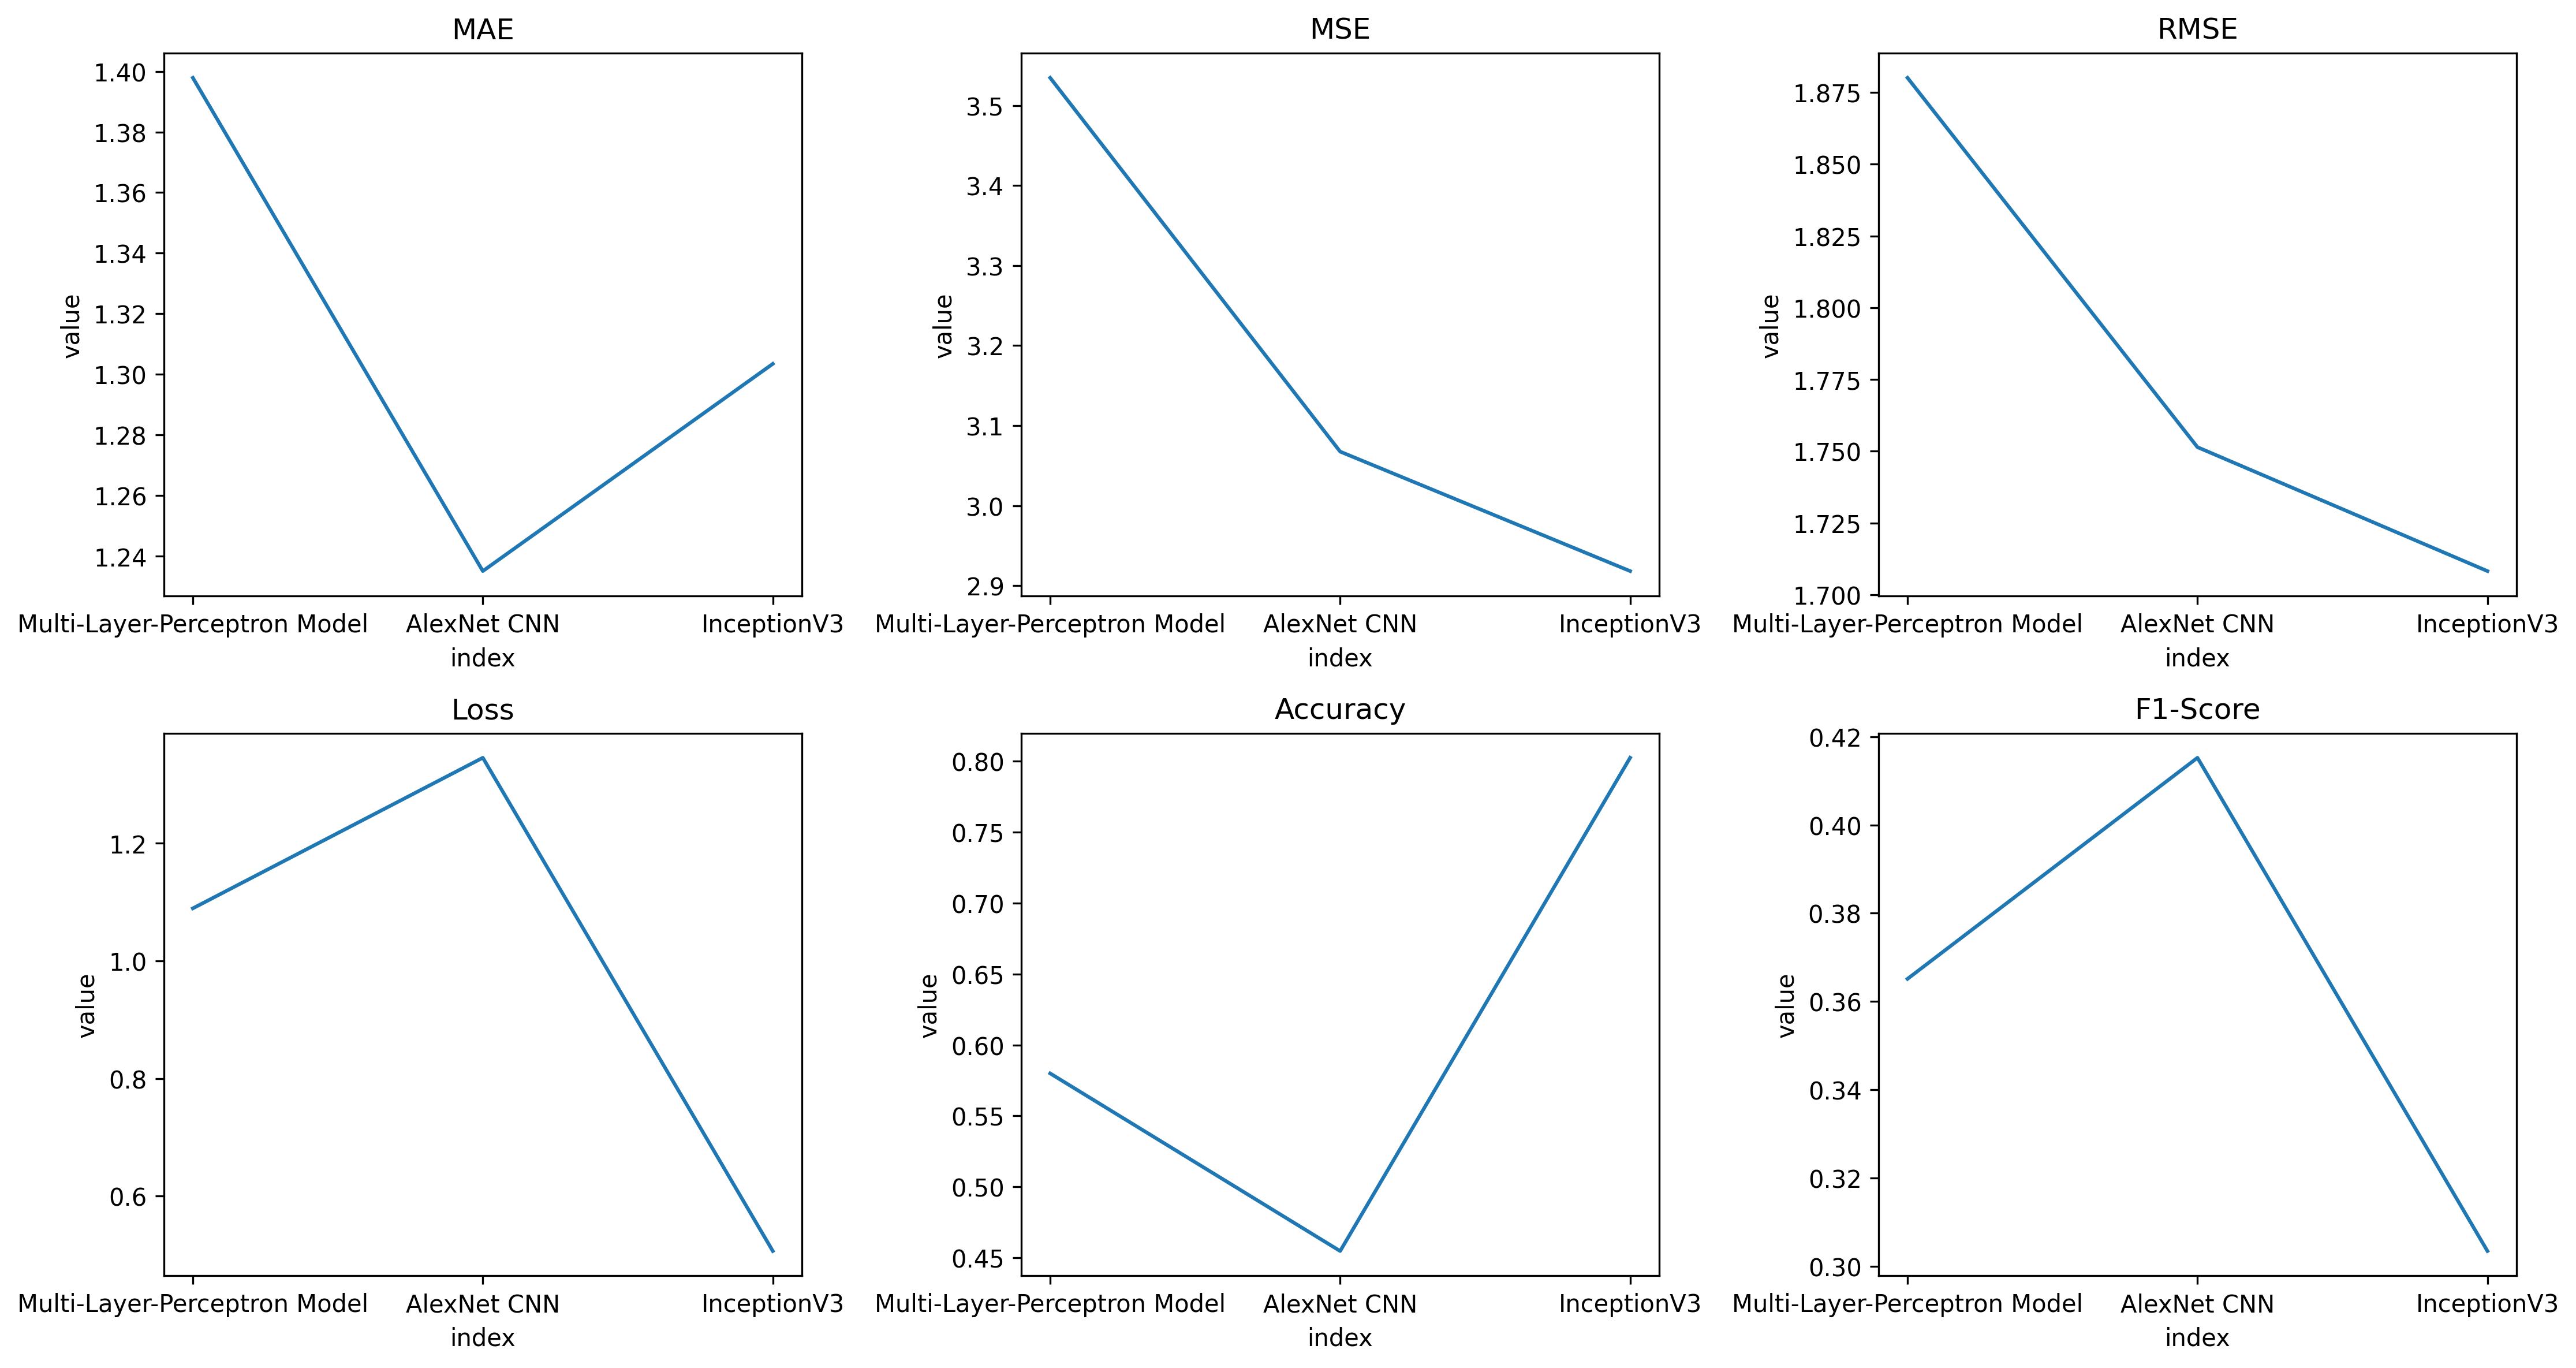

In [68]:
# prompt: Using dataframe final_report_df: generate this plots

import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot MAE
axes[0, 0].plot(final_report_df['MAE'])
axes[0, 0].set_title('MAE')
axes[0, 0].set_xlabel('index')
axes[0, 0].set_ylabel('value')


# Plot MSE
axes[0, 1].plot(final_report_df['MSE'])
axes[0, 1].set_title('MSE')
axes[0, 1].set_xlabel('index')
axes[0, 1].set_ylabel('value')

# Plot RMSE
axes[0, 2].plot(final_report_df['RMSE'])
axes[0, 2].set_title('RMSE')
axes[0, 2].set_xlabel('index')
axes[0, 2].set_ylabel('value')

# Plot Loss
axes[1, 0].plot(final_report_df['Loss'])
axes[1, 0].set_title('Loss')
axes[1, 0].set_xlabel('index')
axes[1, 0].set_ylabel('value')

#Plot Accuracy
axes[1, 1].plot(final_report_df['Accuracy'])
axes[1,1].set_title('Accuracy')
axes[1, 1].set_xlabel('index')
axes[1, 1].set_ylabel('value')

#Plot F1-Score
axes[1, 2].plot(final_report_df['F1-Score'])
axes[1, 2].set_title('F1-Score')
axes[1, 2].set_xlabel('index')
axes[1, 2].set_ylabel('value')


# Adjust layout
plt.tight_layout()
plt.show()
